In [146]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set() 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [147]:
# Read in the data
df = pd.read_csv('./Data/box_office_flat_file.csv', header=0)

# ID isn't needed for analysis
df = df.drop('ID', axis=1)

## Data Preprocessing

Let's convert Dtypes of each column to the right Dtype:

In [148]:
class DtypeTransformer:
    """Converts the columns in col_names to the specified dtype"""
    def __init__(self, df):
        self.df = df

    def transform(self, col_names, dtype):
        self.df[col_names] = self.df[col_names].astype(dtype)
        return self.df
    
    def transform_to_bull(self):
        
        #  Find all numeric columns
        column_names = df.select_dtypes(include=[np.number]).columns 

        # re-extracting the columns of numerical type (using awesome np.number1 :)) then getting the max of those and storing them in a temporary variable m.
        m = df[df.select_dtypes(include=[np.number]).columns].max().reset_index(name='max')
        n = m.loc[m['max']==1, 'max']

        # Extracted the indexes of the rows from n and stored them in temporary variable p.
        # These indexes are the same as the indexes from original dataframe 'df'.
        p = column_names[n.index]
        
        return self.transform(p, 'bool')

# We can use the DtypeTransformer to convert the columns to the correct dtypes
# Sending only features to transform
transformer = DtypeTransformer(df)

# Set boolean values to 'bool' dtype
transformer.transform_to_bull()

# Convert Categorical column to 'category' dtype
cat_column_names = ['OriginLang', 'CatRuntime', 'Genre']
transformer.transform(cat_column_names, 'category')

# Convert 'ReleaseDate' to datetime
transformer.transform('ReleaseDate', 'datetime64[ns]')

# Creating list of columns name by data type
bool_columns = list(df.select_dtypes(include=['bool']).columns)
cat_columns = list(df.select_dtypes(include=['category']).columns)
numeric_columns = list(df.select_dtypes(include=['int64', 'float64']).columns)
target_column = ['Revenue']



## Visualize correlation with a diagonal correlation plot

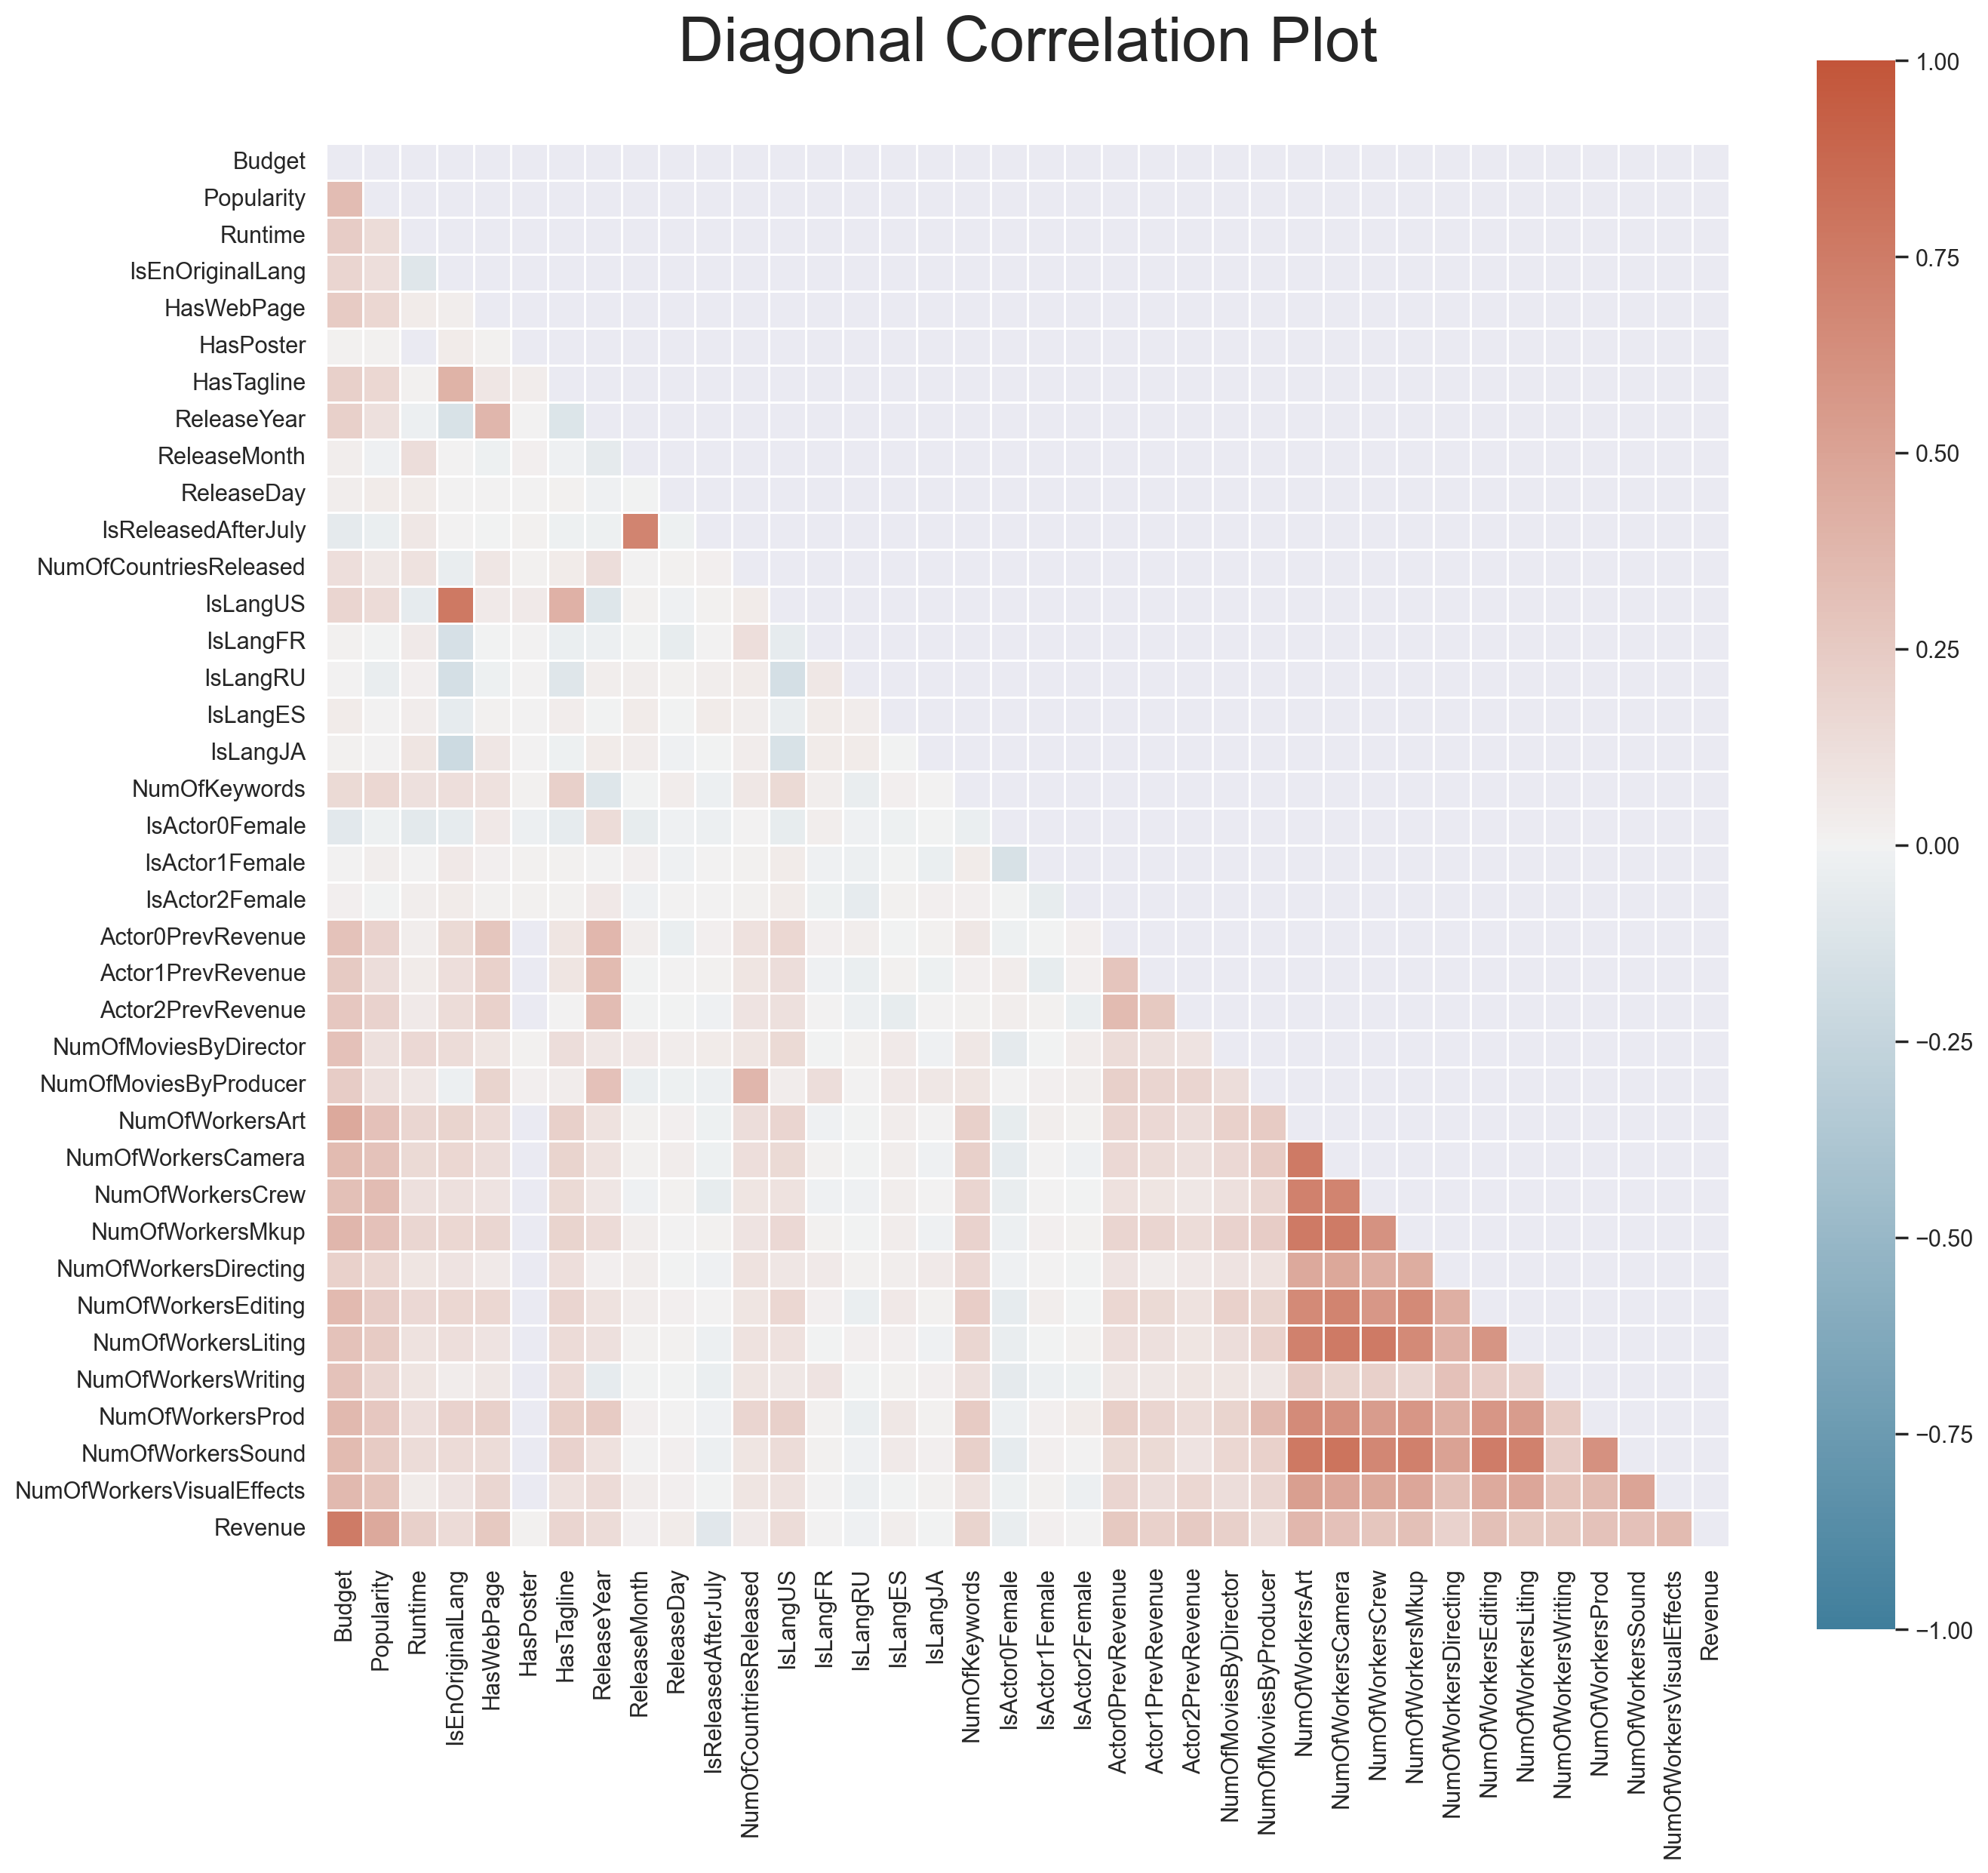

In [149]:
# Compute the correlation matrix with pearson correlation
corr = df.corr(method = 'pearson')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 15))                    # Set figure size

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask 
sns.heatmap(corr, 
            mask = mask, 
            cmap = cmap, 
            vmax = 1,                                      # Set scale min value
            vmin = -1,                                     # Set scale min value
            center = 0,                                    # Set scale min value
            square = True,                                 # Ensure perfect squares
            linewidths = 1,                                # Set linewidth between squares
            cbar_kws = {"shrink": .9},                     # Set size of color bar
           );

plt.xticks(rotation=90)                                    # Rotate x labels
plt.yticks()
plt.title('Diagonal Correlation Plot', size=30, y=1.05);   # Set plot title and position

We see there exist a correlation between the sizes of the department crews (nothing spacial)


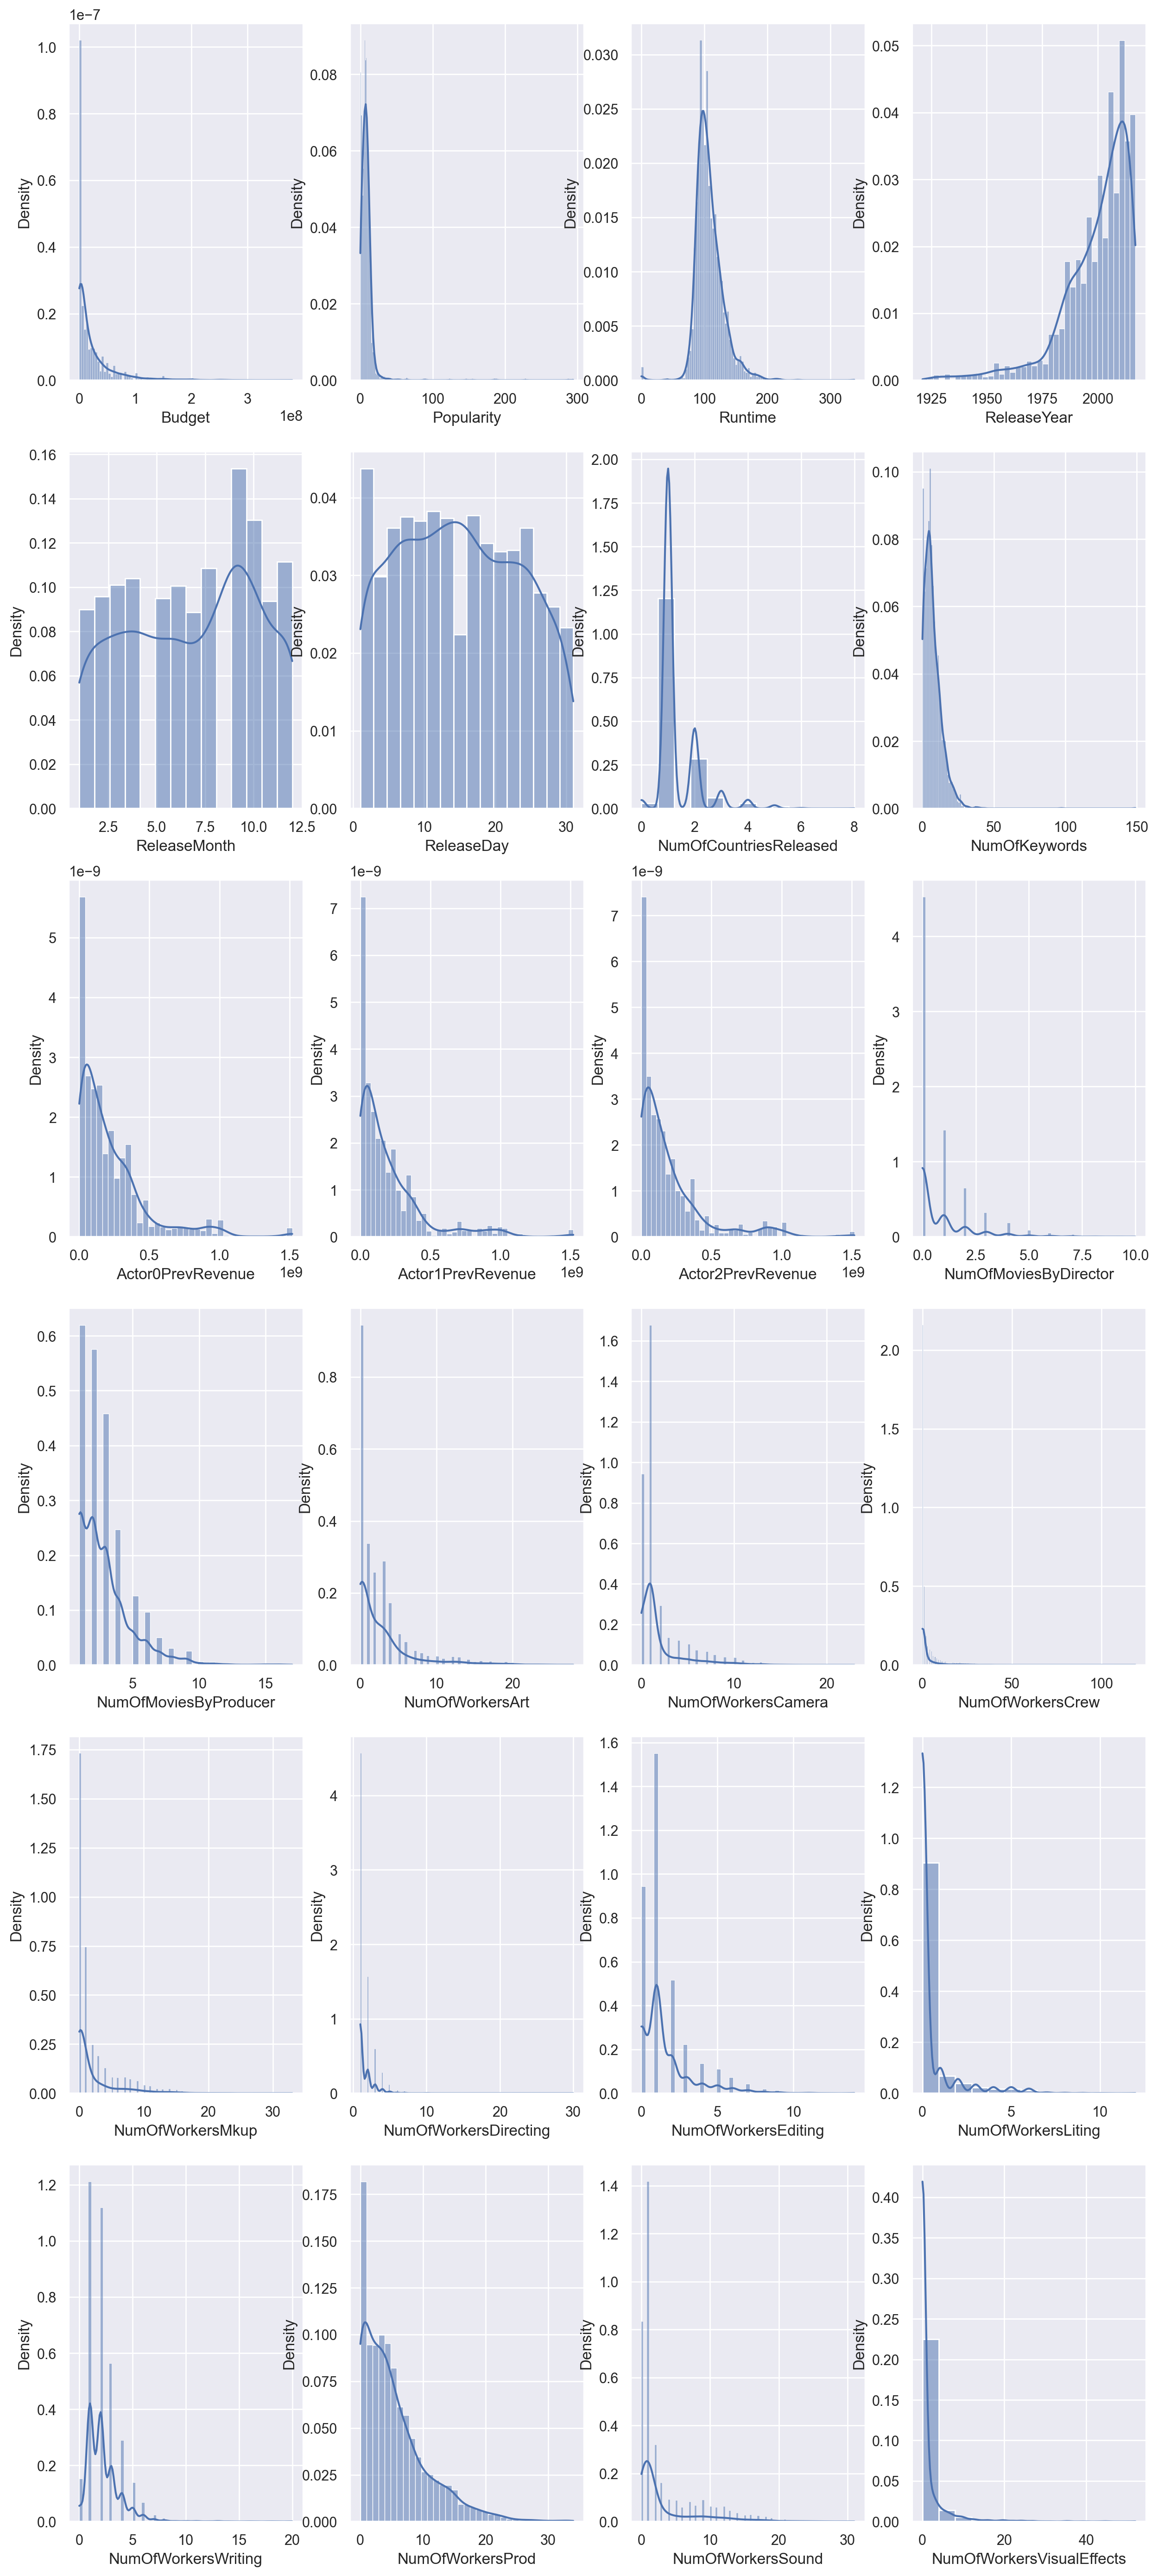

In [150]:
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=len(numeric_columns) // 4, ncols=4, figsize=(15, 35))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, axis in zip(numeric_columns, axes):
    sns.histplot(data=df[numeric_columns], x=col, ax=axis, kde=True, stat='density')
plt.show()


Let's plot the categorial features in respect to Revenue

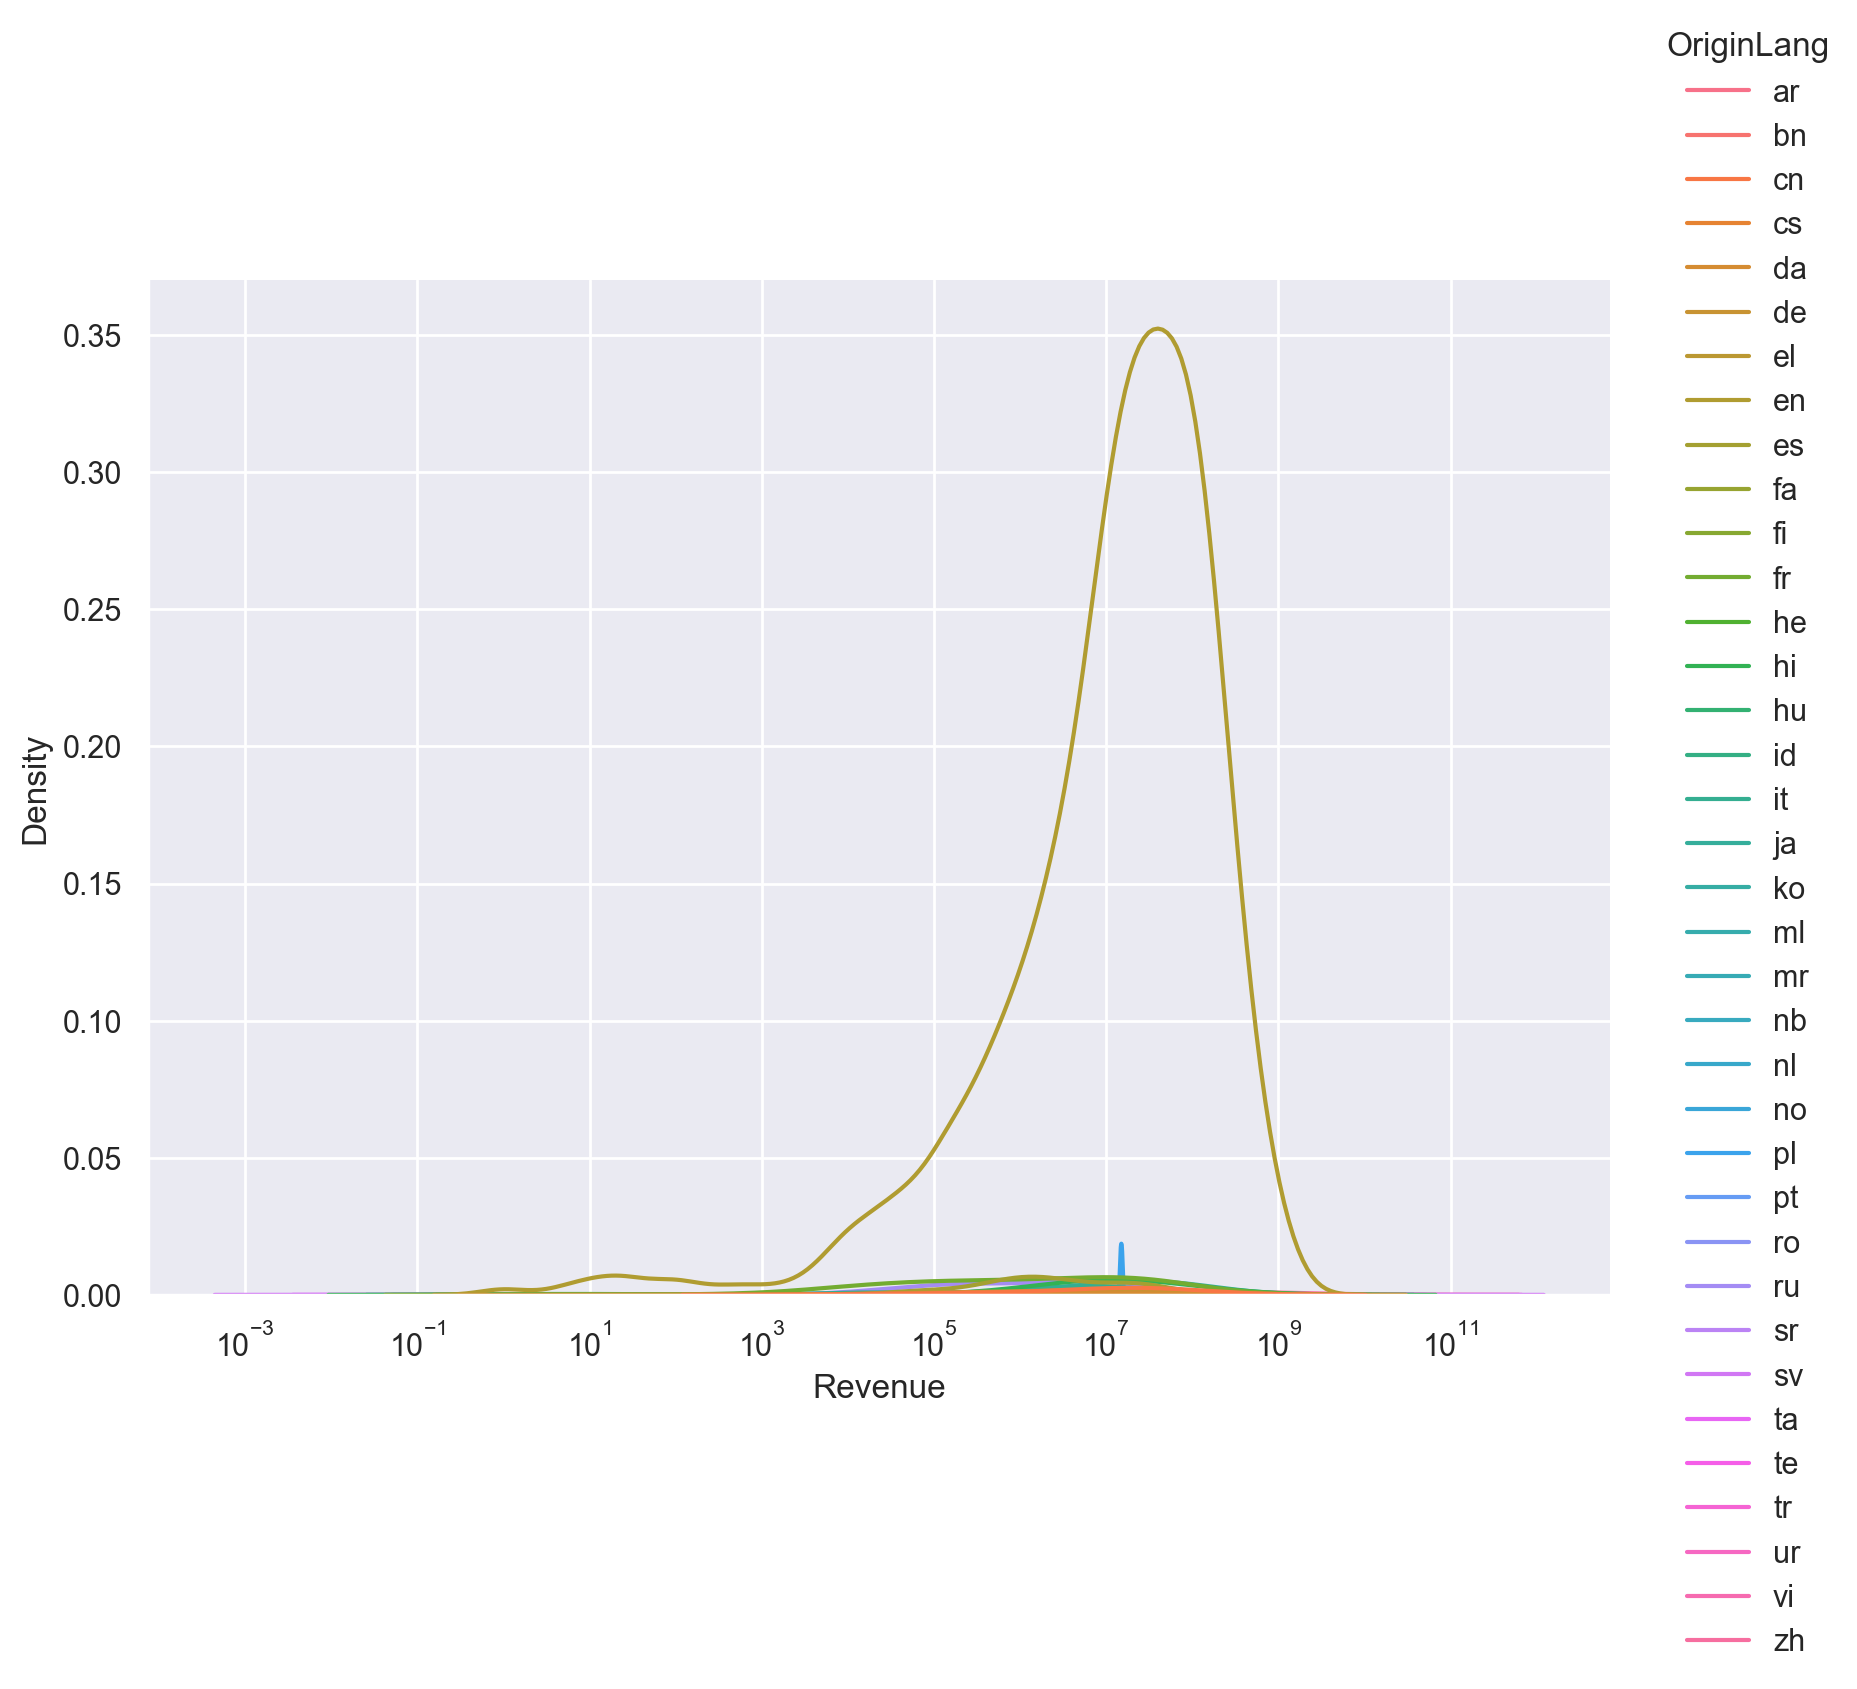

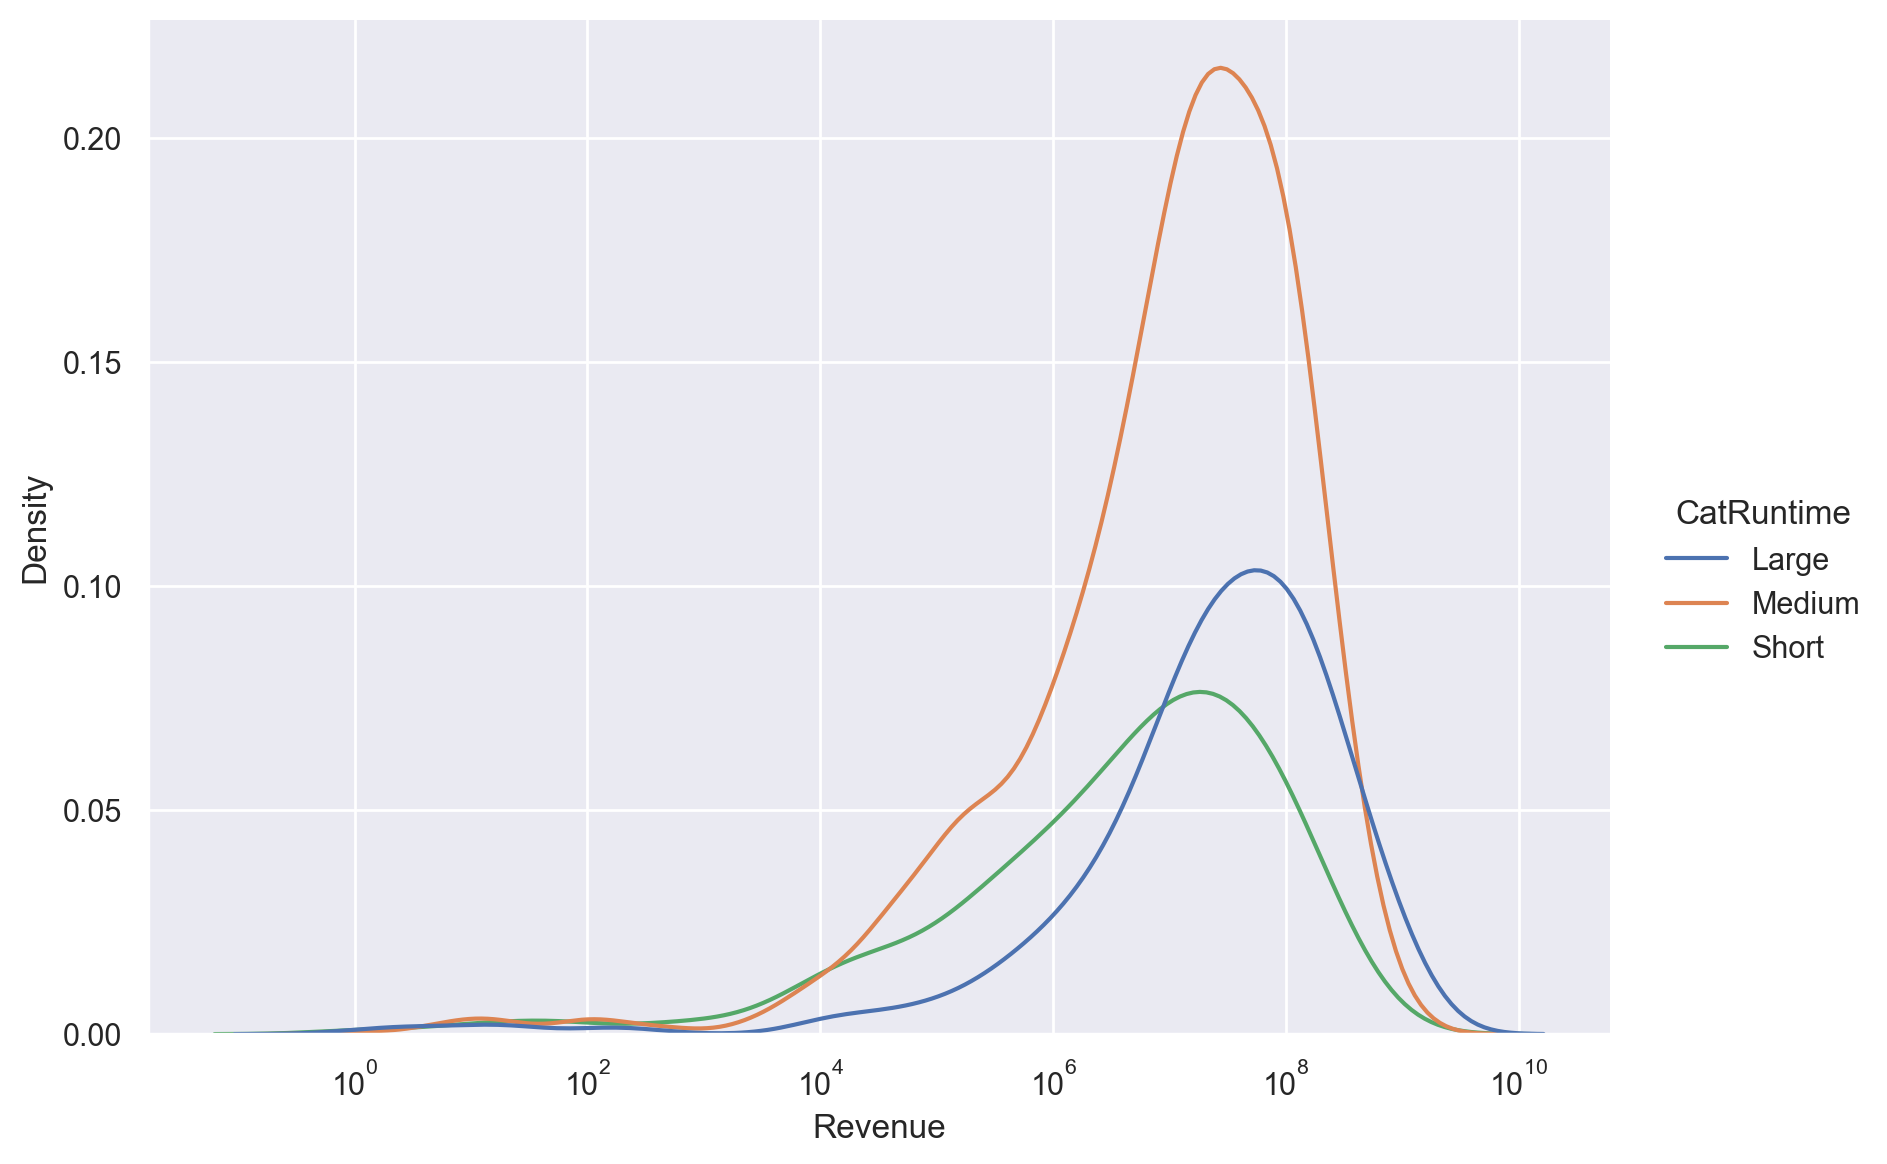

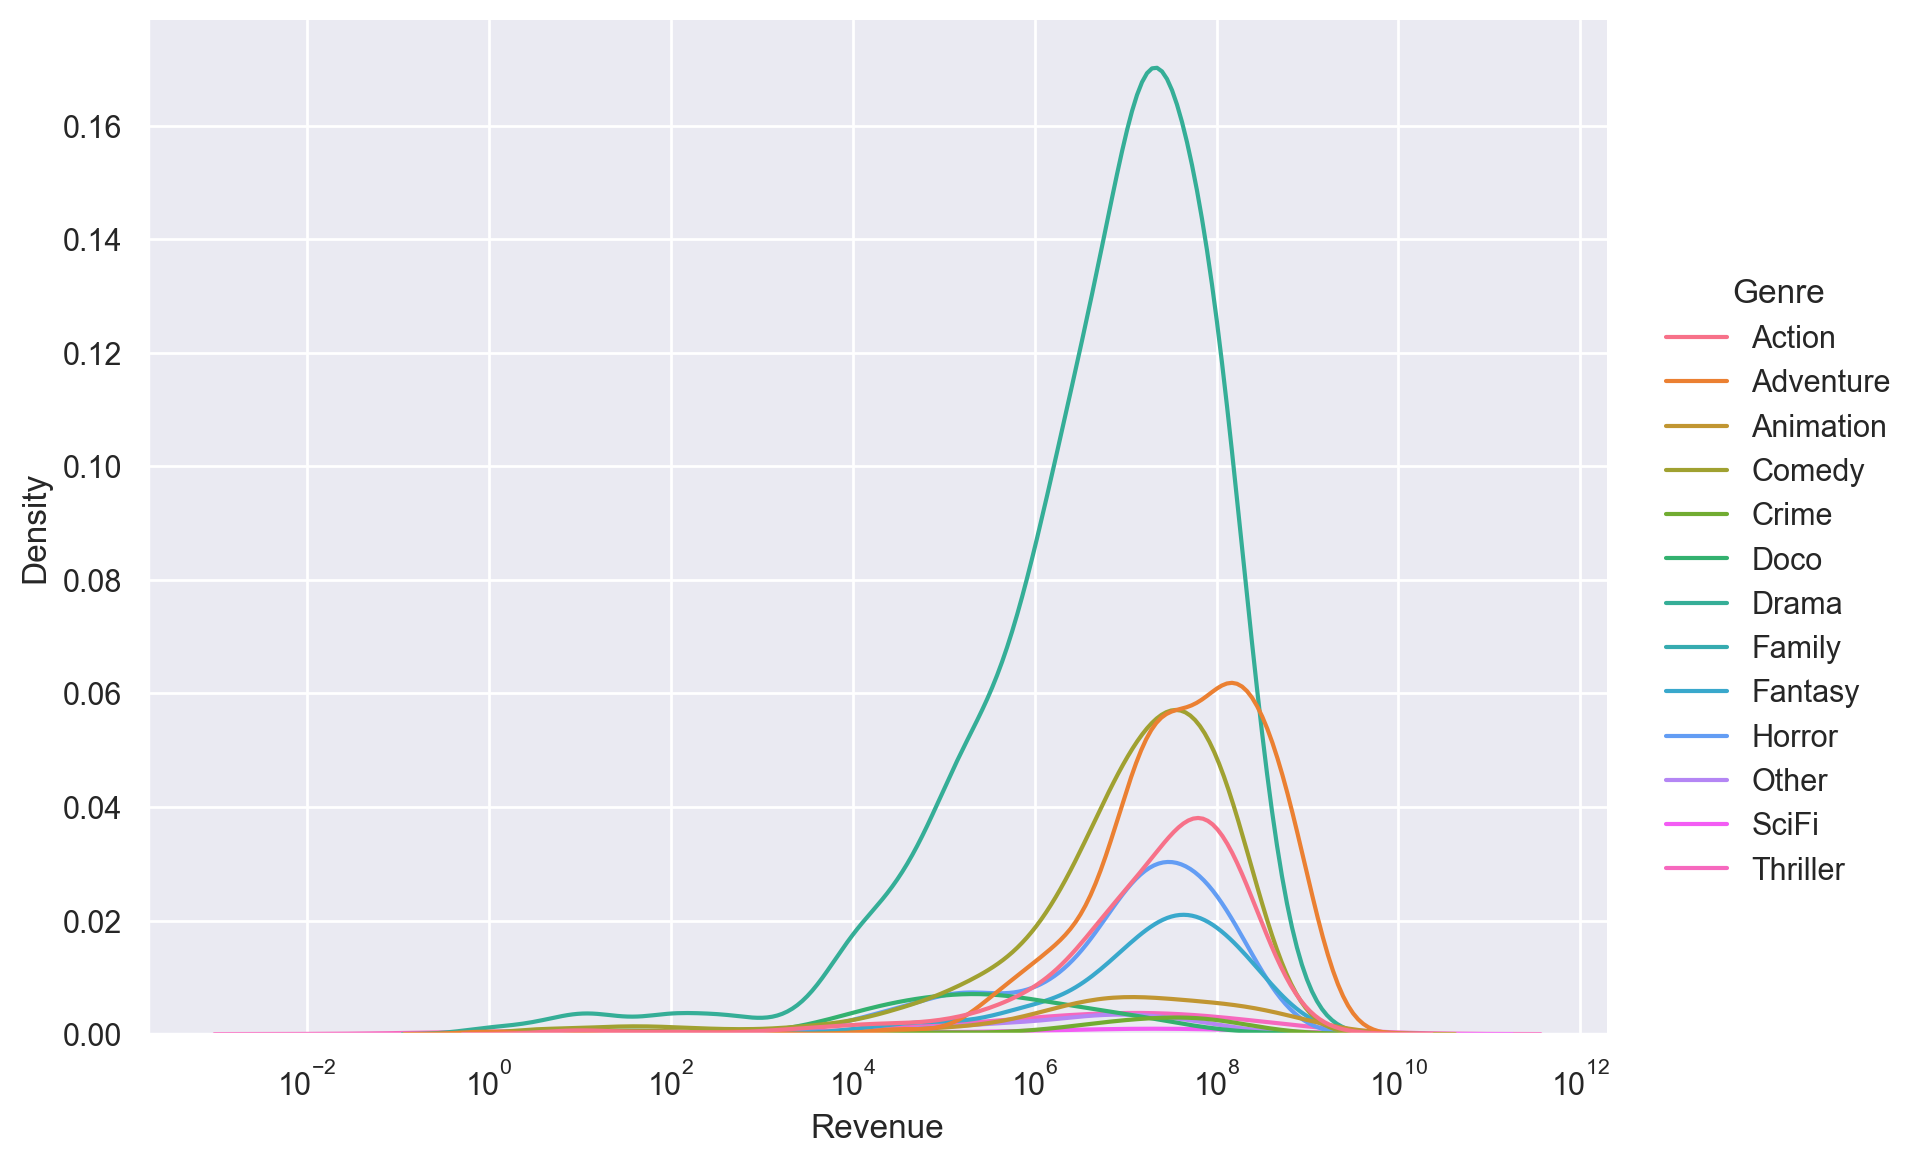

In [151]:
for cat in cat_columns:
    sns.displot(data=df, x="Revenue", hue=cat, kind="kde",
                height=6, aspect=1.4, log_scale=10, warn_singular=False,
                legend=True)
    

## Describe and plot the target variable -
First lets see how the target variable distributed

Just by looking on the data it easy to notice that there are outliers (in features and target variables).

 Later I will deal with them..

count    3.000000e+03
mean     6.672585e+07
std      1.375323e+08
min      1.000000e+00
25%      2.379808e+06
50%      1.680707e+07
75%      6.891920e+07
max      1.519558e+09
Name: Revenue, dtype: float64

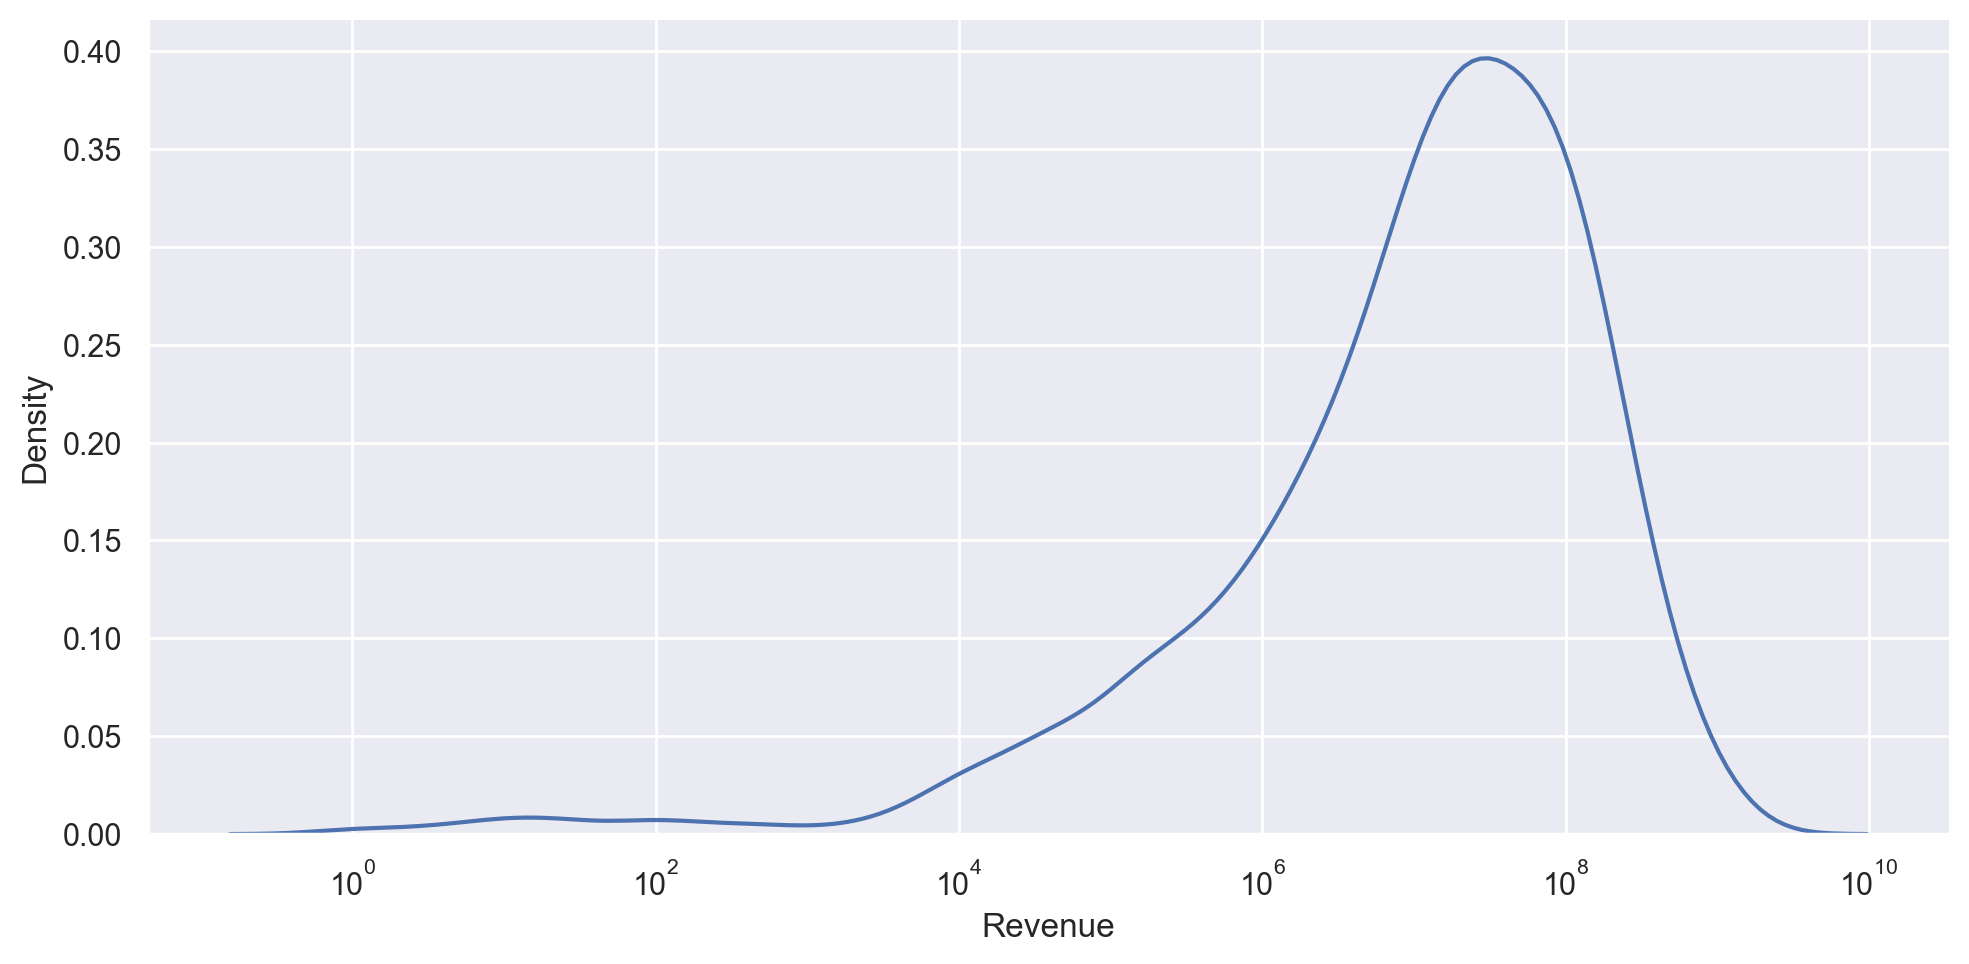

In [152]:
# df.drop(df.query("Revenue > (0.4*1e9)").index, inplace=True)
sns.displot(df.Revenue, kind='kde', height=5, aspect=2, log_scale=10)
df.Revenue.describe()

### Explore nullity of the df

We would like to print only columns have null values in df

Runtime                         2
Actor0PrevRevenue             934
Actor1PrevRevenue            1157
Actor2PrevRevenue            1245
NumOfMoviesByProducer         592
NumOfWorkersArt                16
NumOfWorkersCamera             16
NumOfWorkersCrew               16
NumOfWorkersMkup               16
NumOfWorkersDirecting          16
NumOfWorkersEditing            16
NumOfWorkersLiting             16
NumOfWorkersWriting            16
NumOfWorkersProd               16
NumOfWorkersSound              16
NumOfWorkersVisualEffects      16
dtype: int64


<AxesSubplot:>

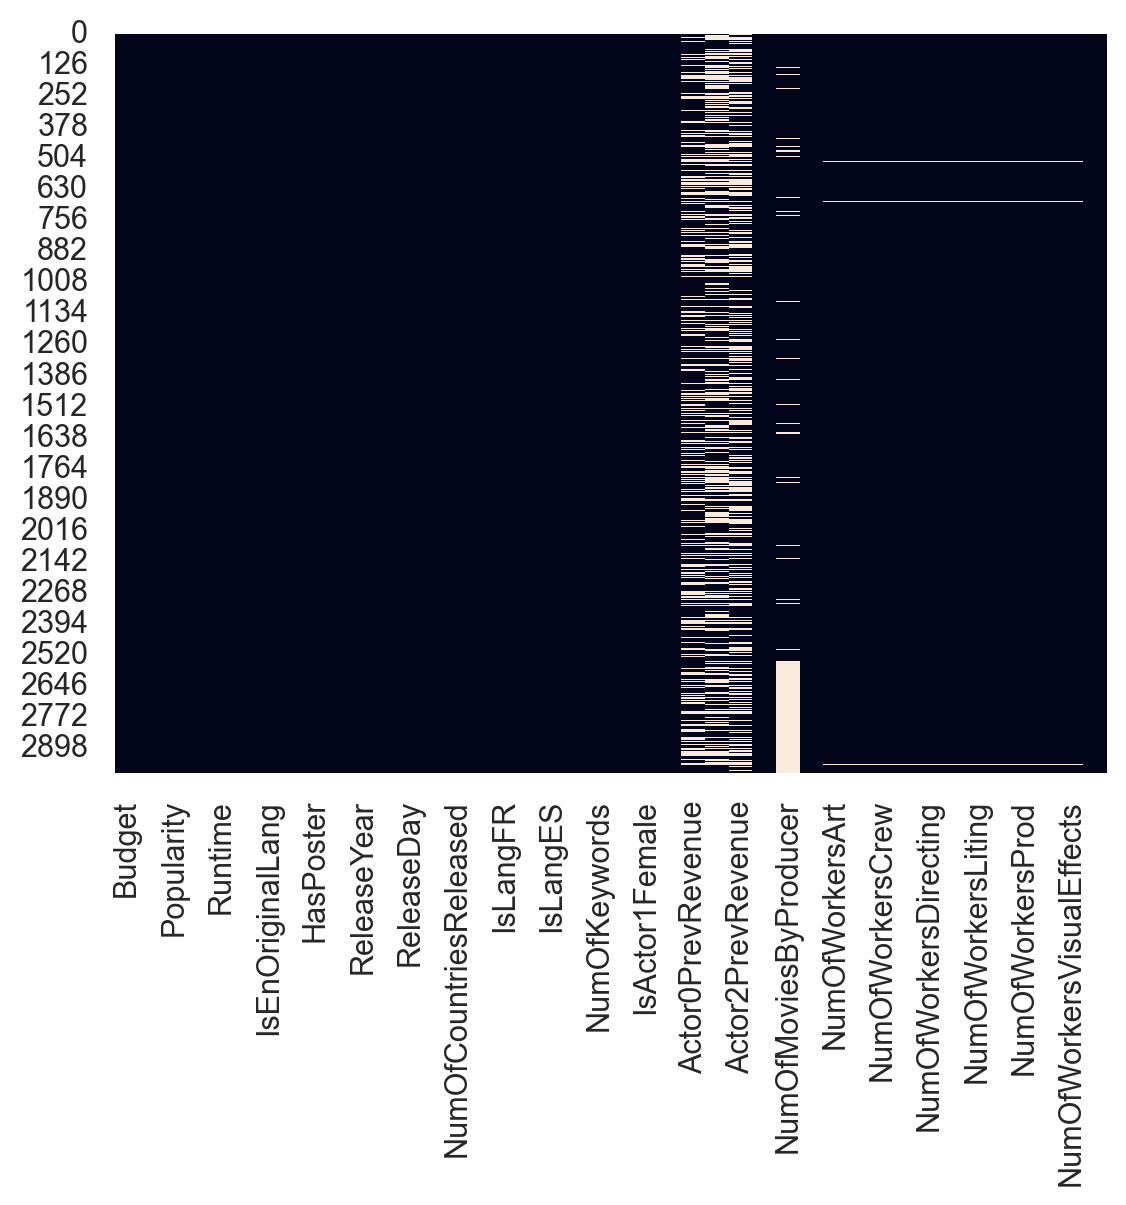

In [153]:
nullseries = df.isnull().sum()
print(nullseries[nullseries>0])
sns.heatmap(df.isnull(), cbar=False)

In [154]:
# There are too many missing values in the 'ActorXPrevRevenue' column - lets remove this columns
df.drop(['Actor0PrevRevenue', 'Actor1PrevRevenue', 'Actor2PrevRevenue'],
        axis=1, inplace=True)
numeric_columns = [elem for elem in numeric_columns if elem not in ['Actor0PrevRevenue', 'Actor1PrevRevenue', 'Actor2PrevRevenue']]

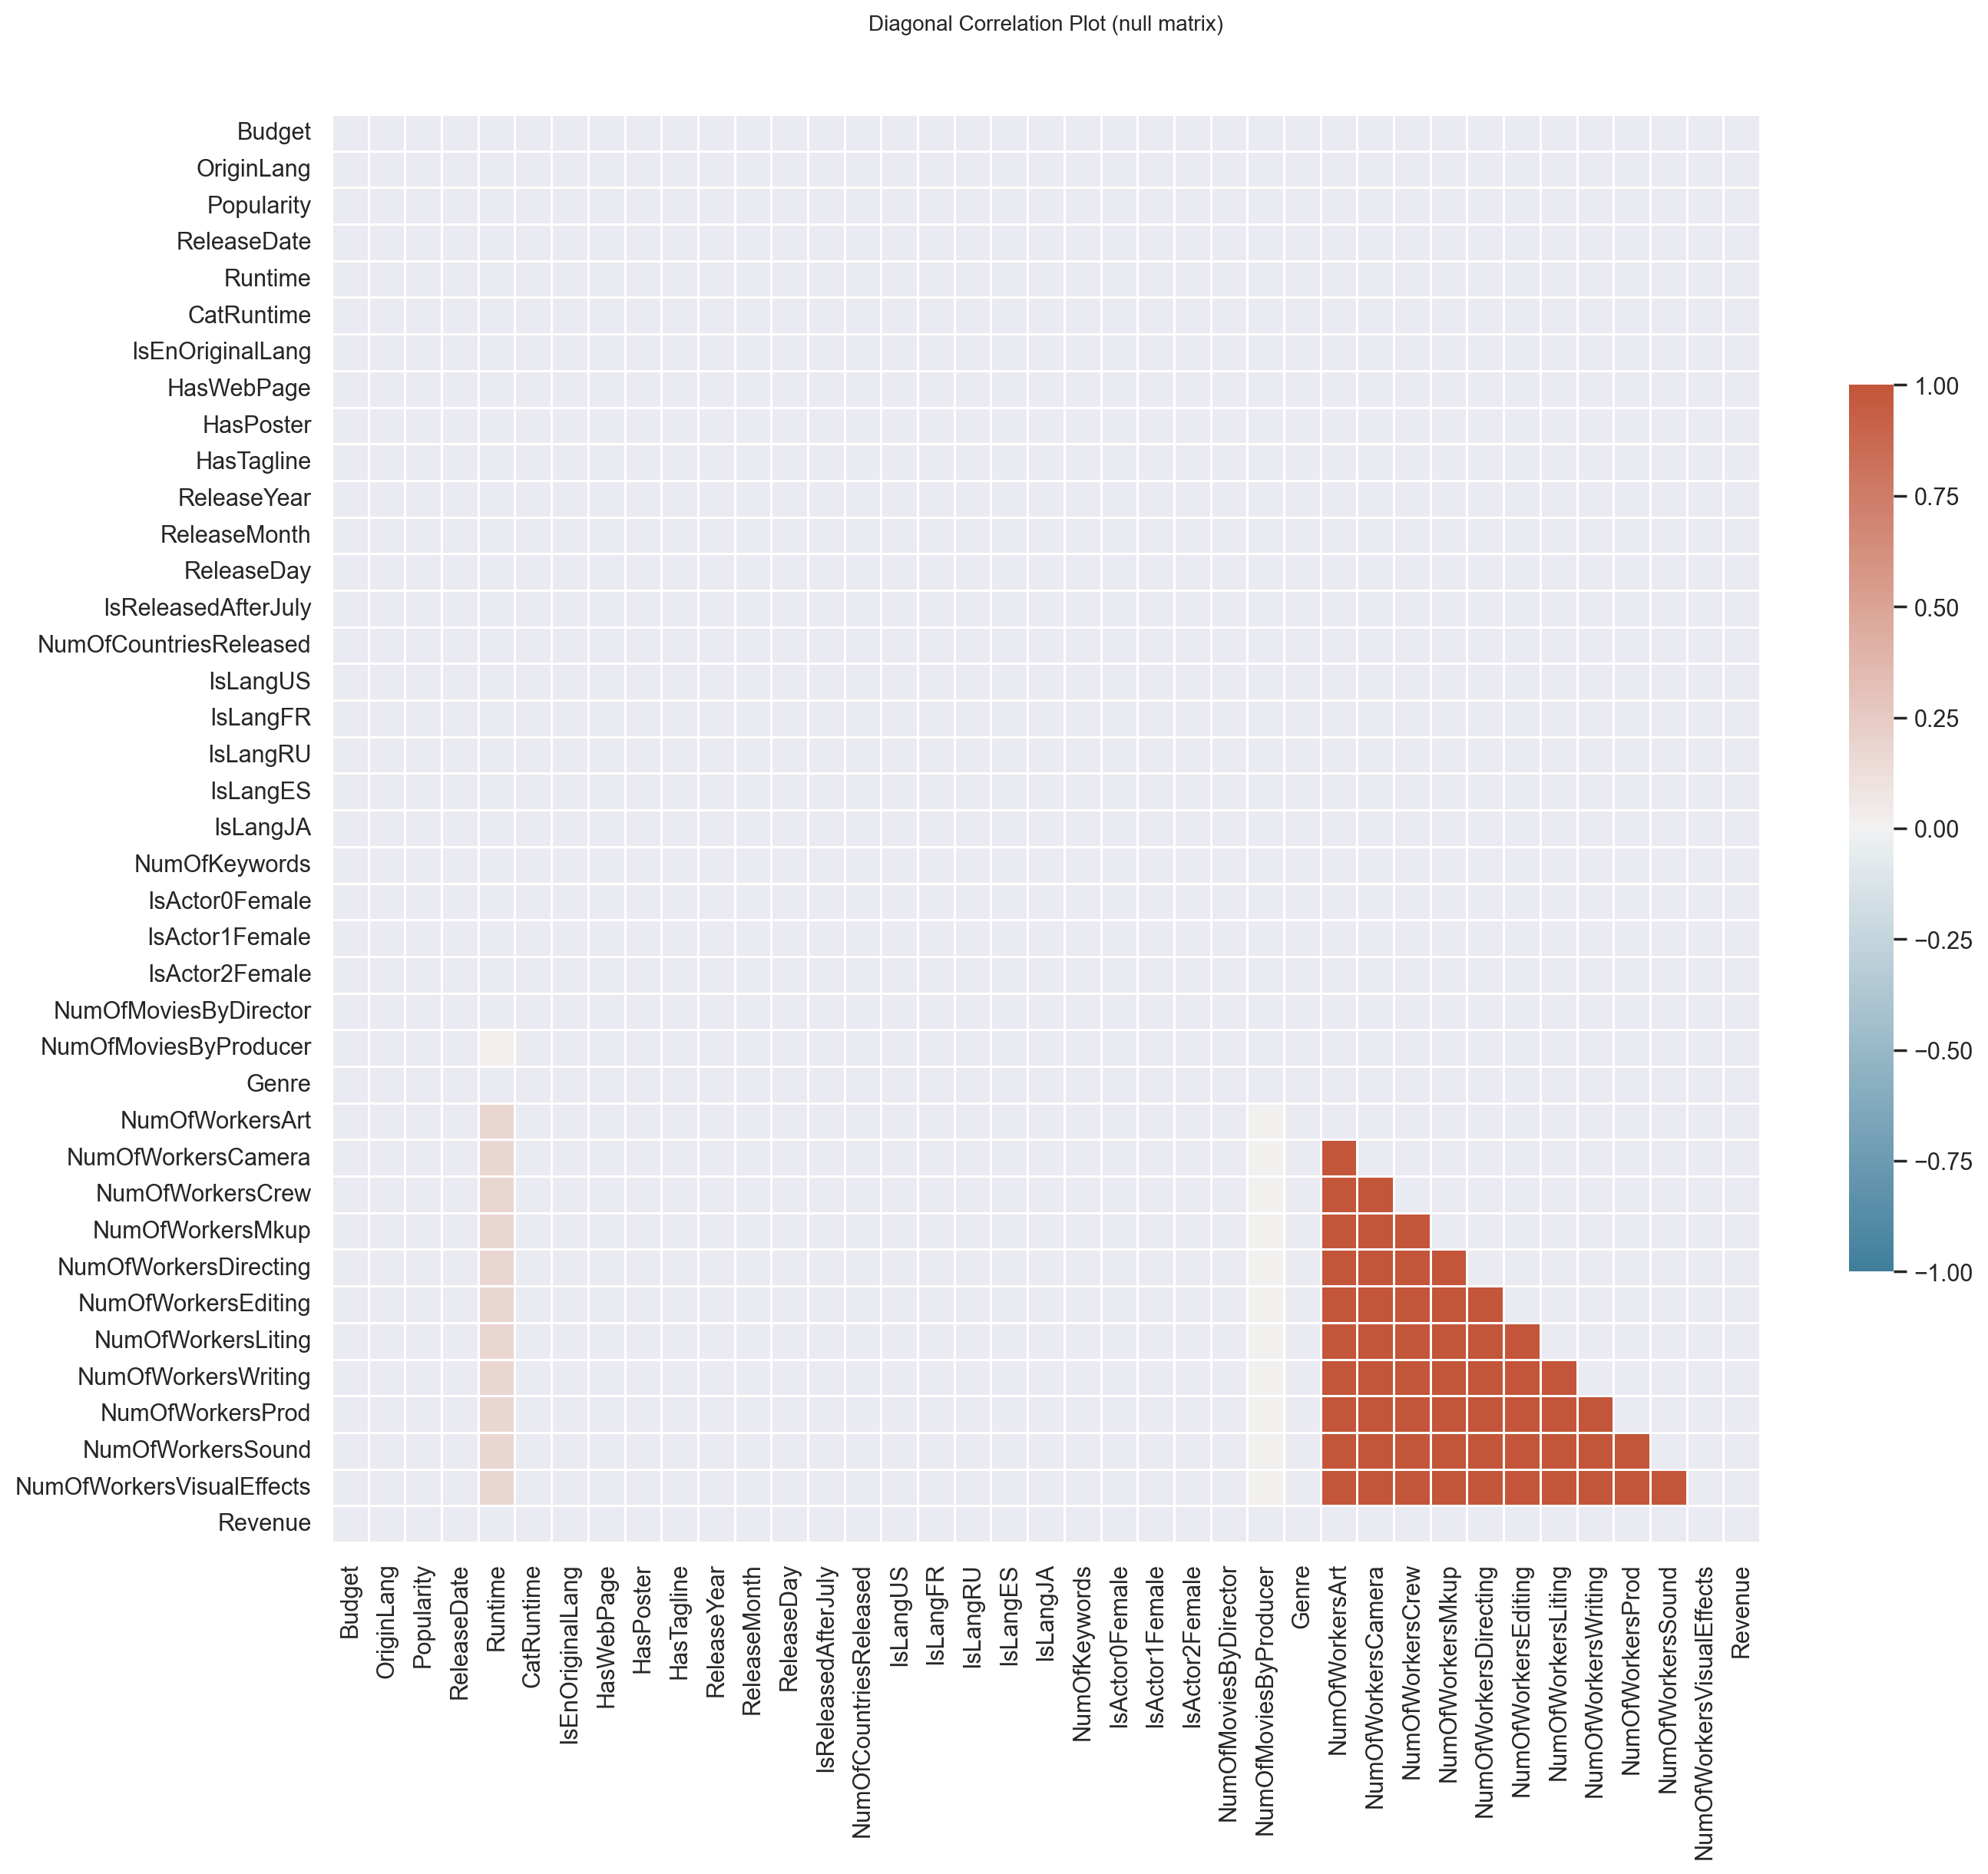

In [155]:
# Compute the correlation matrix of the null df with pearson correlation
null_corr = df.isnull().corr(method = 'pearson')

# Generate a mask for the upper triangle
null_mask = np.triu(np.ones_like(null_corr, dtype=bool))

# Set up the matplotlib figure
null_fig, null_ax = plt.subplots(figsize=(15, 15))                    # Set figure size

# Generate a custom diverging colormap
null_cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask 
sns.heatmap(null_corr, 
            mask = null_mask, 
            cmap = null_cmap, 
            vmax = 1,                                      # Set scale min value
            vmin = -1,                                     # Set scale min value
            center = 0,                                    # Set scale min value
            square = True,                                 # Ensure perfect squares
            linewidths = .5,                               # Set linewidth between squares
            cbar_kws = {"shrink": .5},                     # Set size of color bar
           );

plt.xticks(rotation=90)                                    # Rotate x labels
plt.yticks()
plt.title('Diagonal Correlation Plot (null matrix)', size=10, y=1.05);   # Set plot title and position

### Part 2 - OutLiers 
First, lets use BoxPlot to visualize the outliers then remove them using IQR score

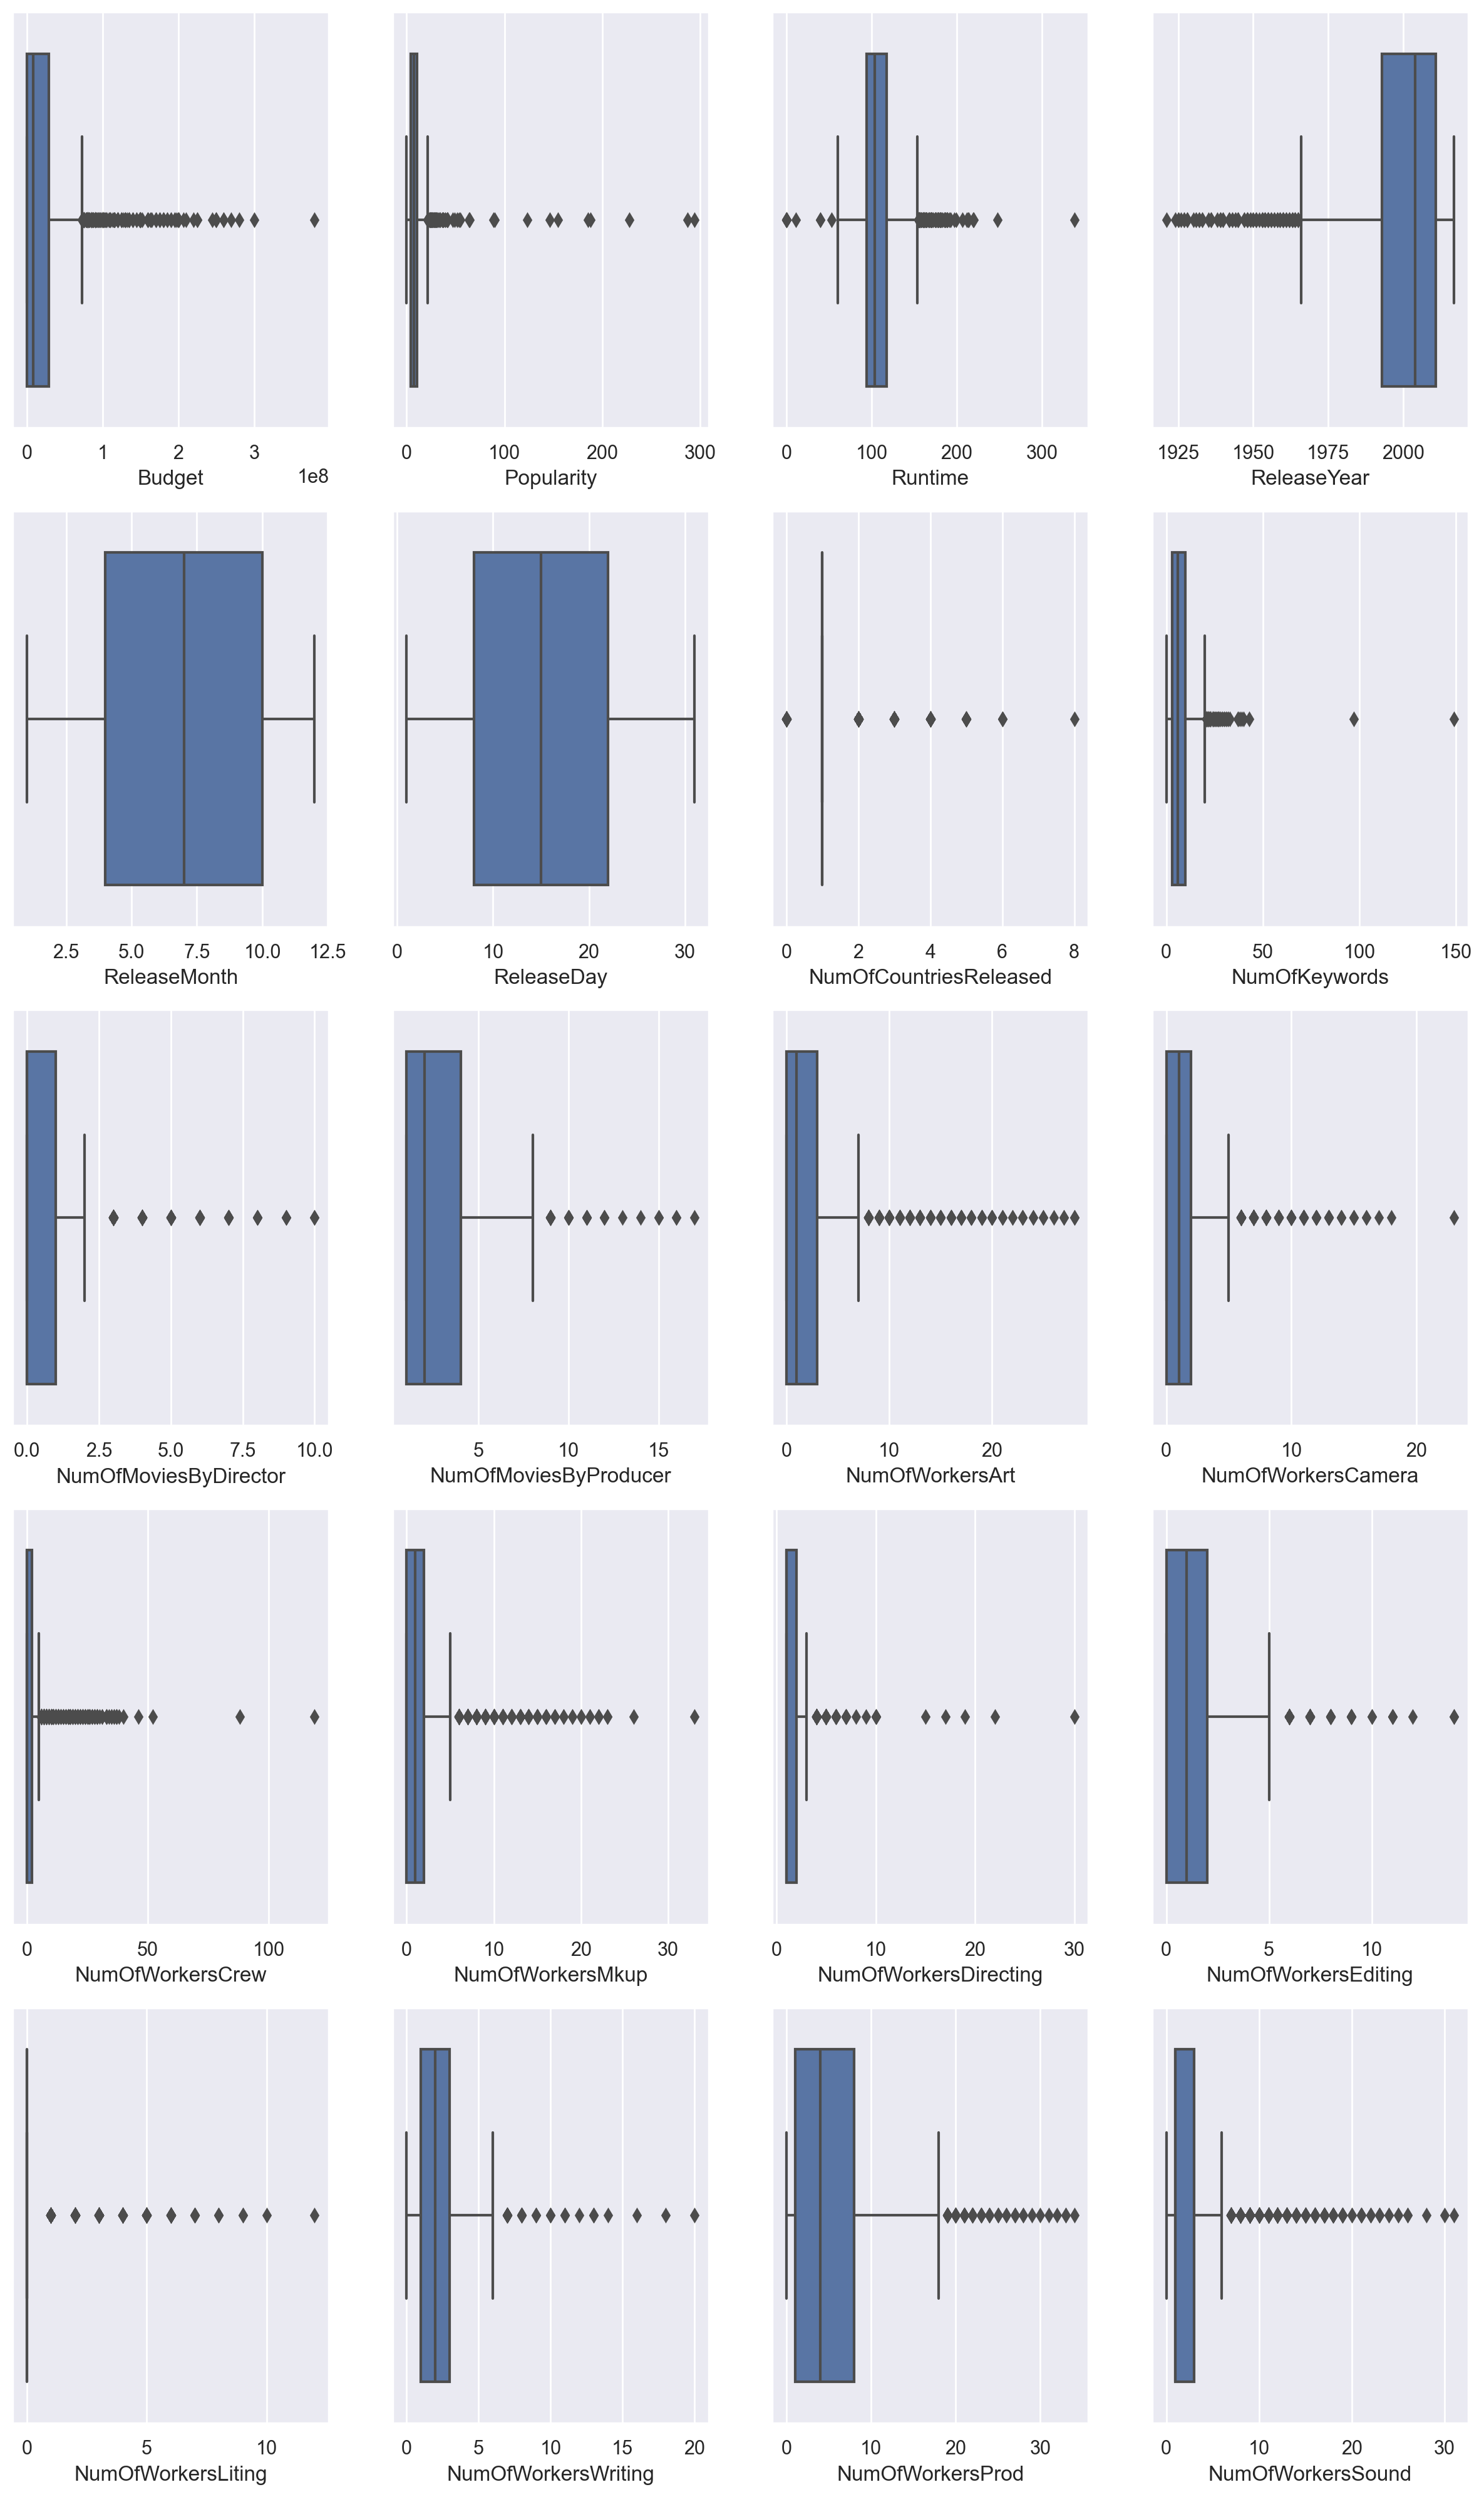

In [156]:
fig, axes = plt.subplots(nrows=len(numeric_columns) // 4, ncols=4, figsize=(15, 25))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, axis in zip(numeric_columns, axes):
    sns.boxplot(data=df, x=col, ax=axis)
plt.show()

We can see that almost in every feature we have outliers. lets remove them and see the impact on the distribution of the data..

Now we can use scatterplot to visualize x ~ y graphs where y is the target feature.
Later we remove outliers and see the change in those graphs

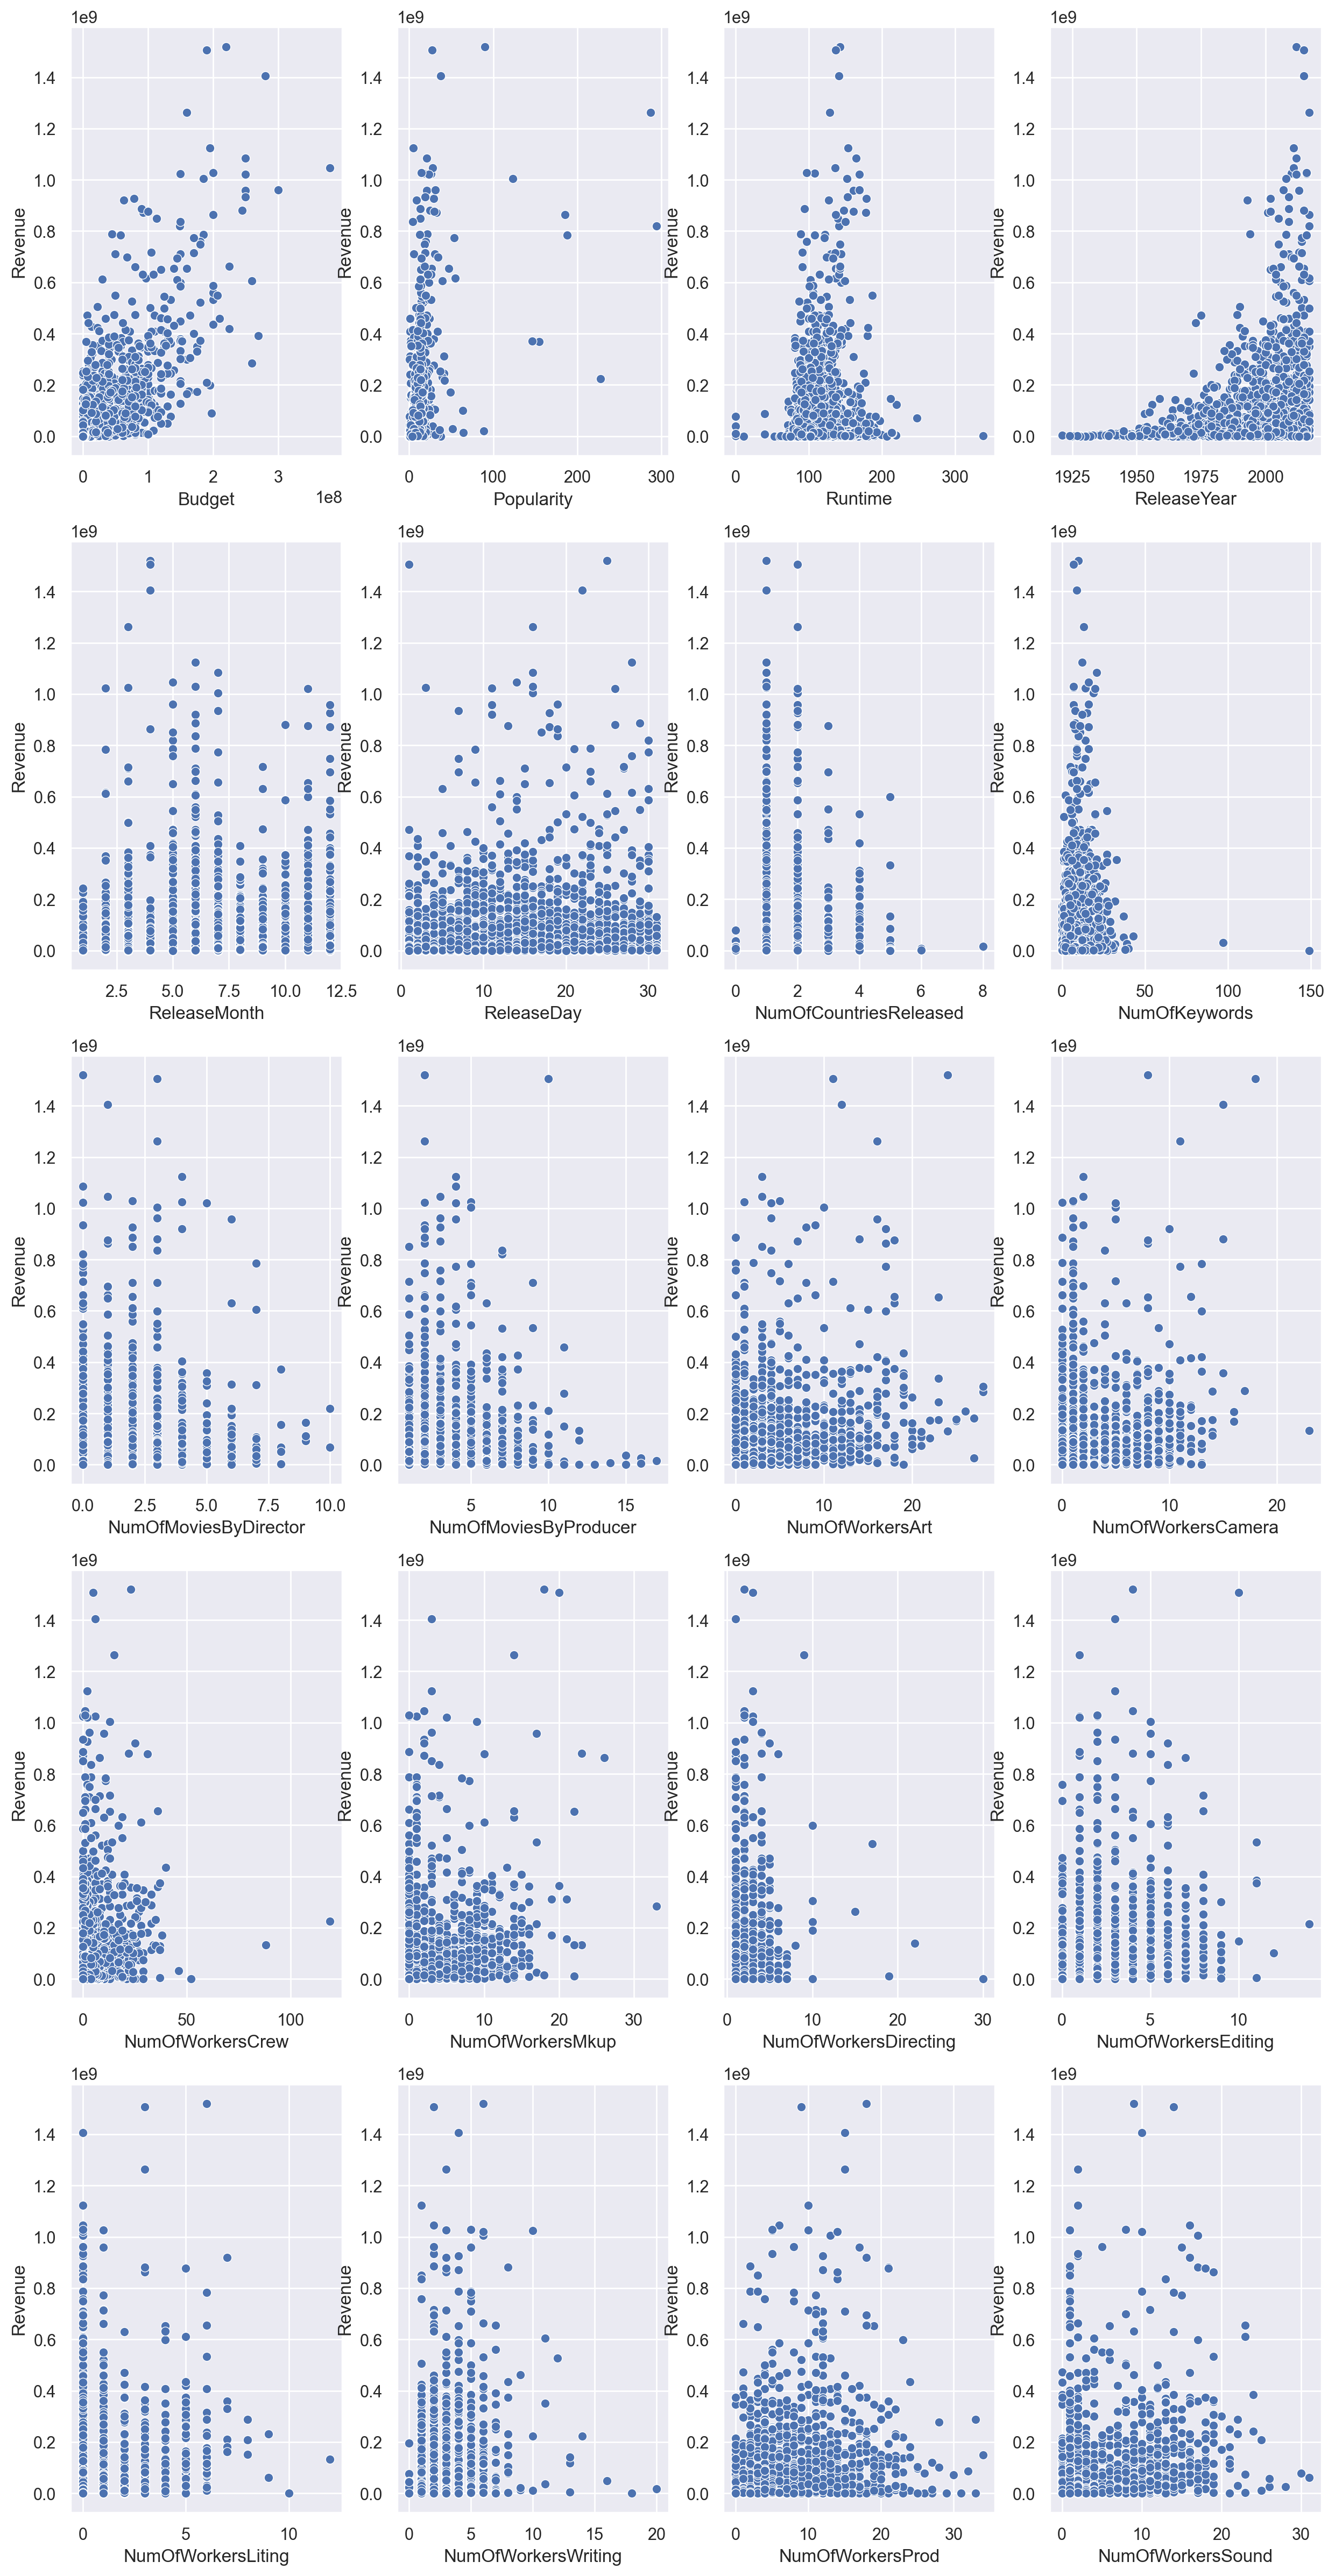

In [157]:
fig, axes = plt.subplots(nrows=len(numeric_columns) // 4, ncols=4, figsize=(15, 30))
axes = axes.ravel()  # flattening the array makes indexing easier
for col, axis in zip(numeric_columns, axes):
    sns.scatterplot(data=df, x=col, y='Revenue', ax=axis)

Search for the outliers using IQR method

In [158]:
# Set up the matplotlib figure
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

for feature in IQR.index:
    # those features we don't want to remove outliers from
    if str(feature) in ['Budget', 'ReleaseYear', 'ReleaseDay', 'ReleaseMonth', 'Revenue']:
        continue
    
    df = df[~((df[feature] < (Q1[feature] - 1.5 * IQR[feature])) | (df[feature] > (Q3[feature] + 1.5 * IQR[feature])))]
df.shape

(1294, 39)

We can remove rows we have outliers in:
  - As we can see, we are removing only rows containing numerical values (not cat/bool/timestamps). This is because in most cases the outliers impact most in values far from the median of a numerical value.

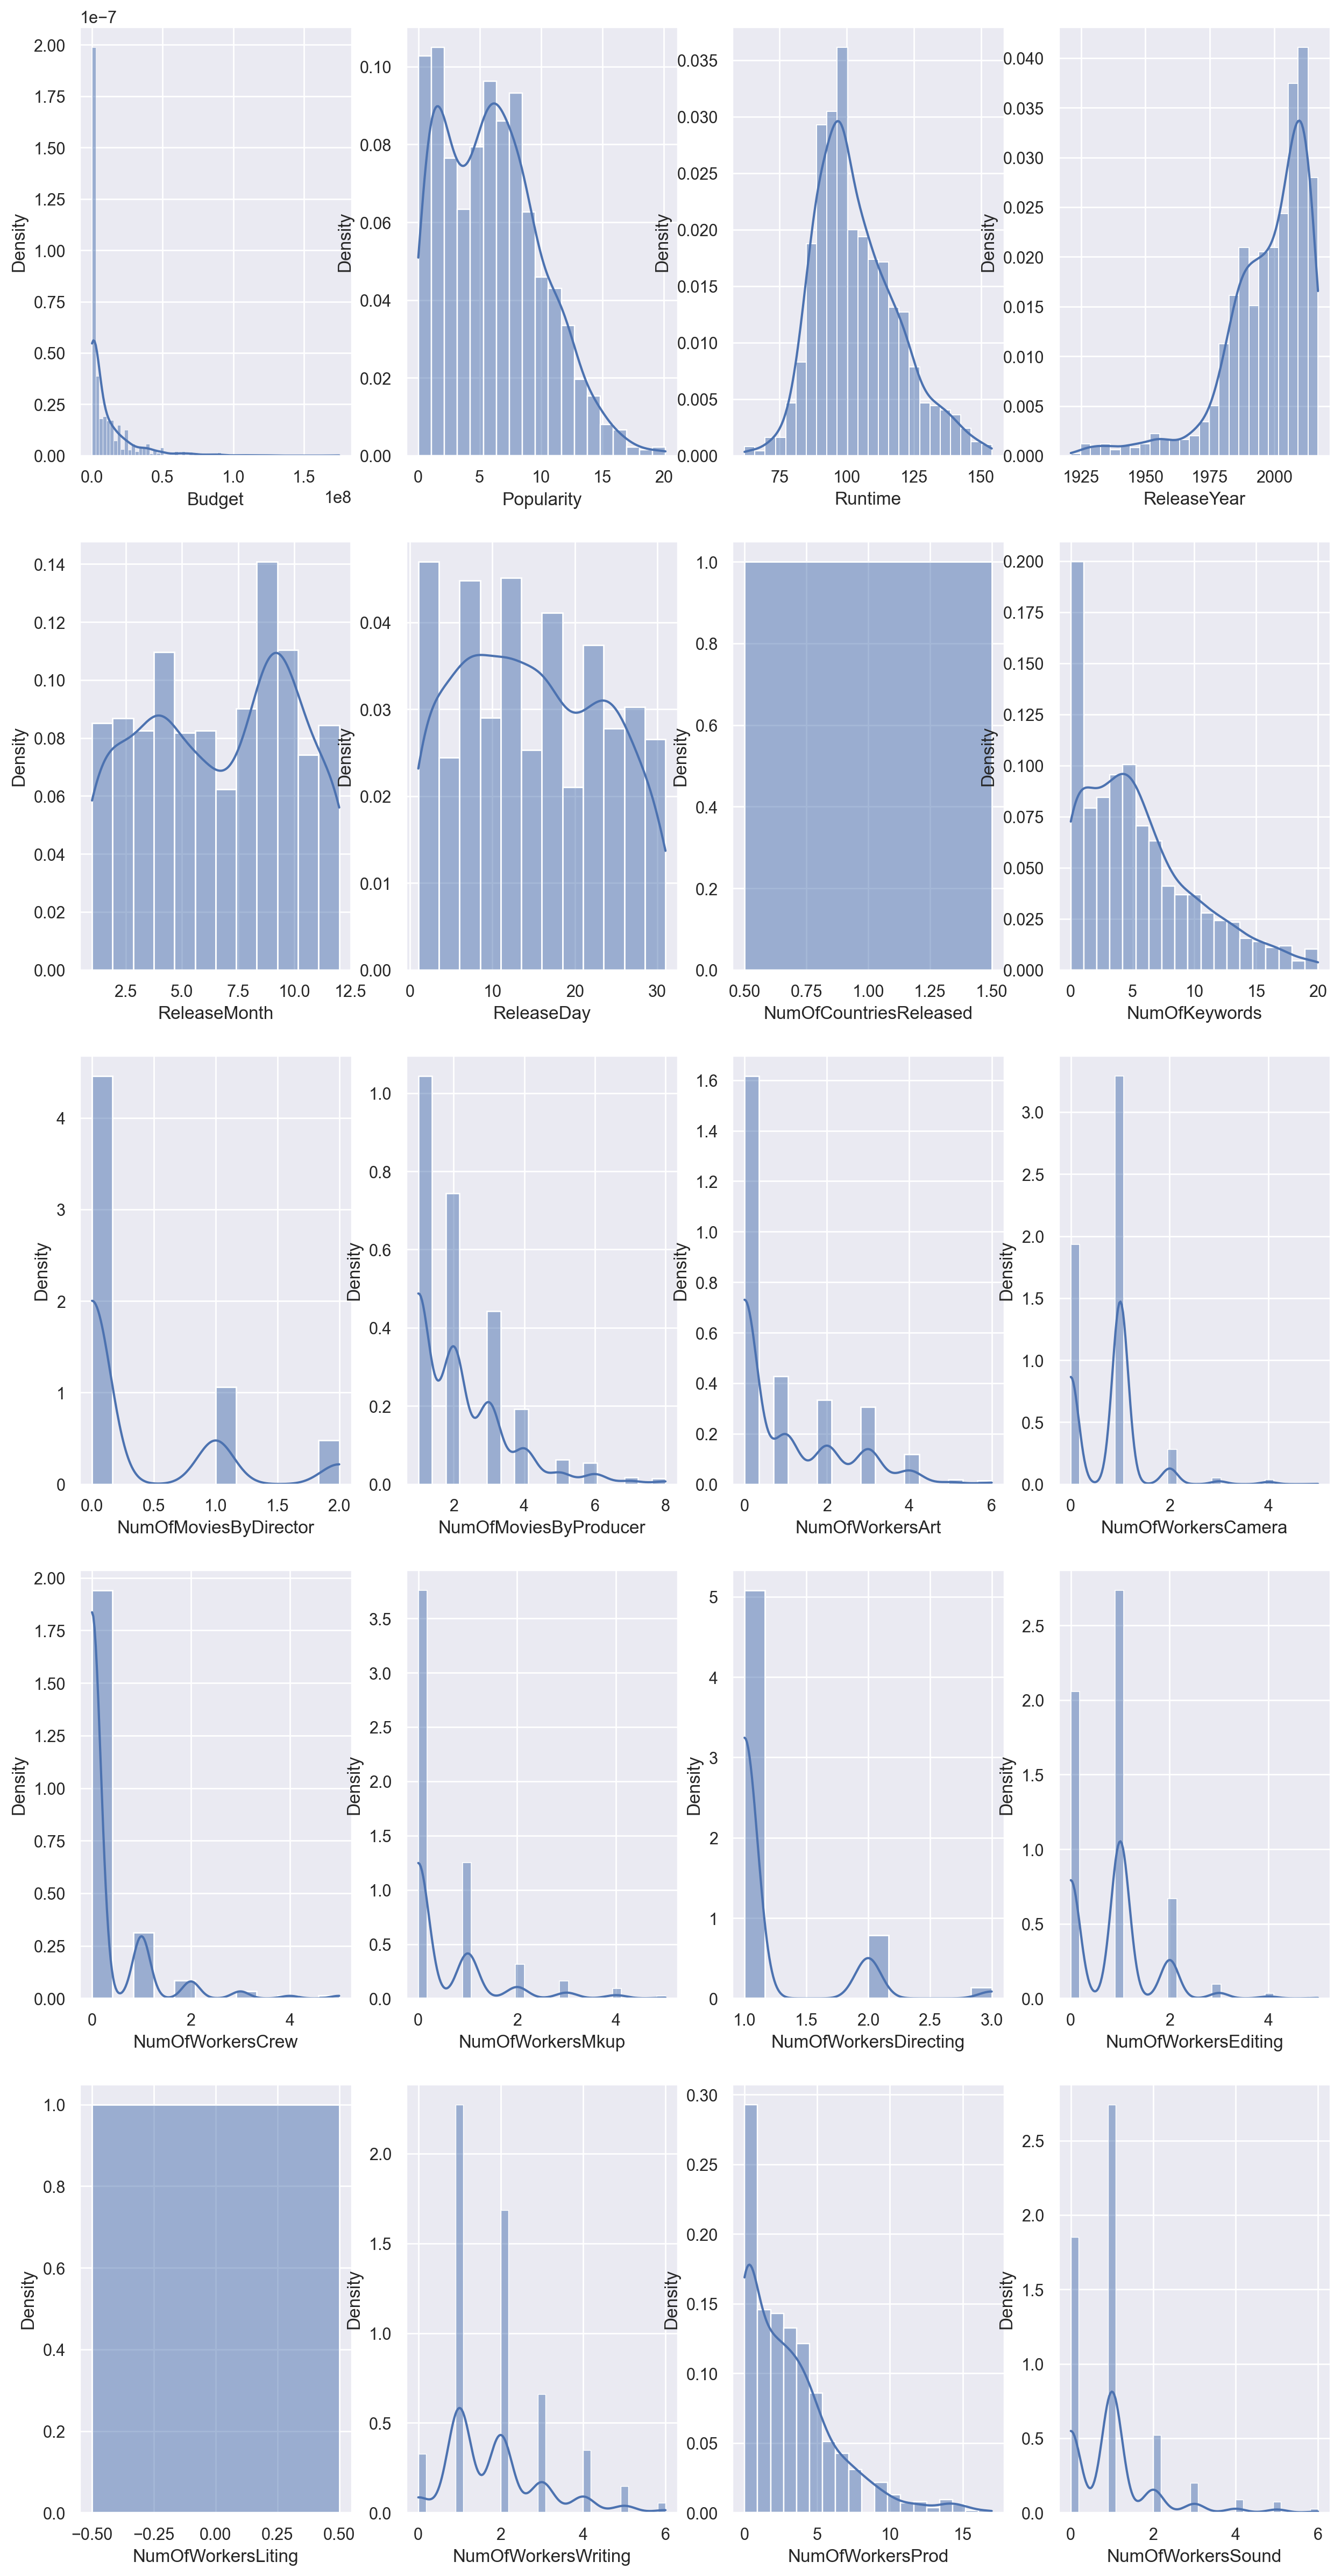

In [159]:
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=len(numeric_columns) // 4, ncols=4, figsize=(15, 30))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, axis in zip(numeric_columns, axes):
    sns.histplot(data=df, x=col, ax=axis, kde=True, stat='density')
plt.show()


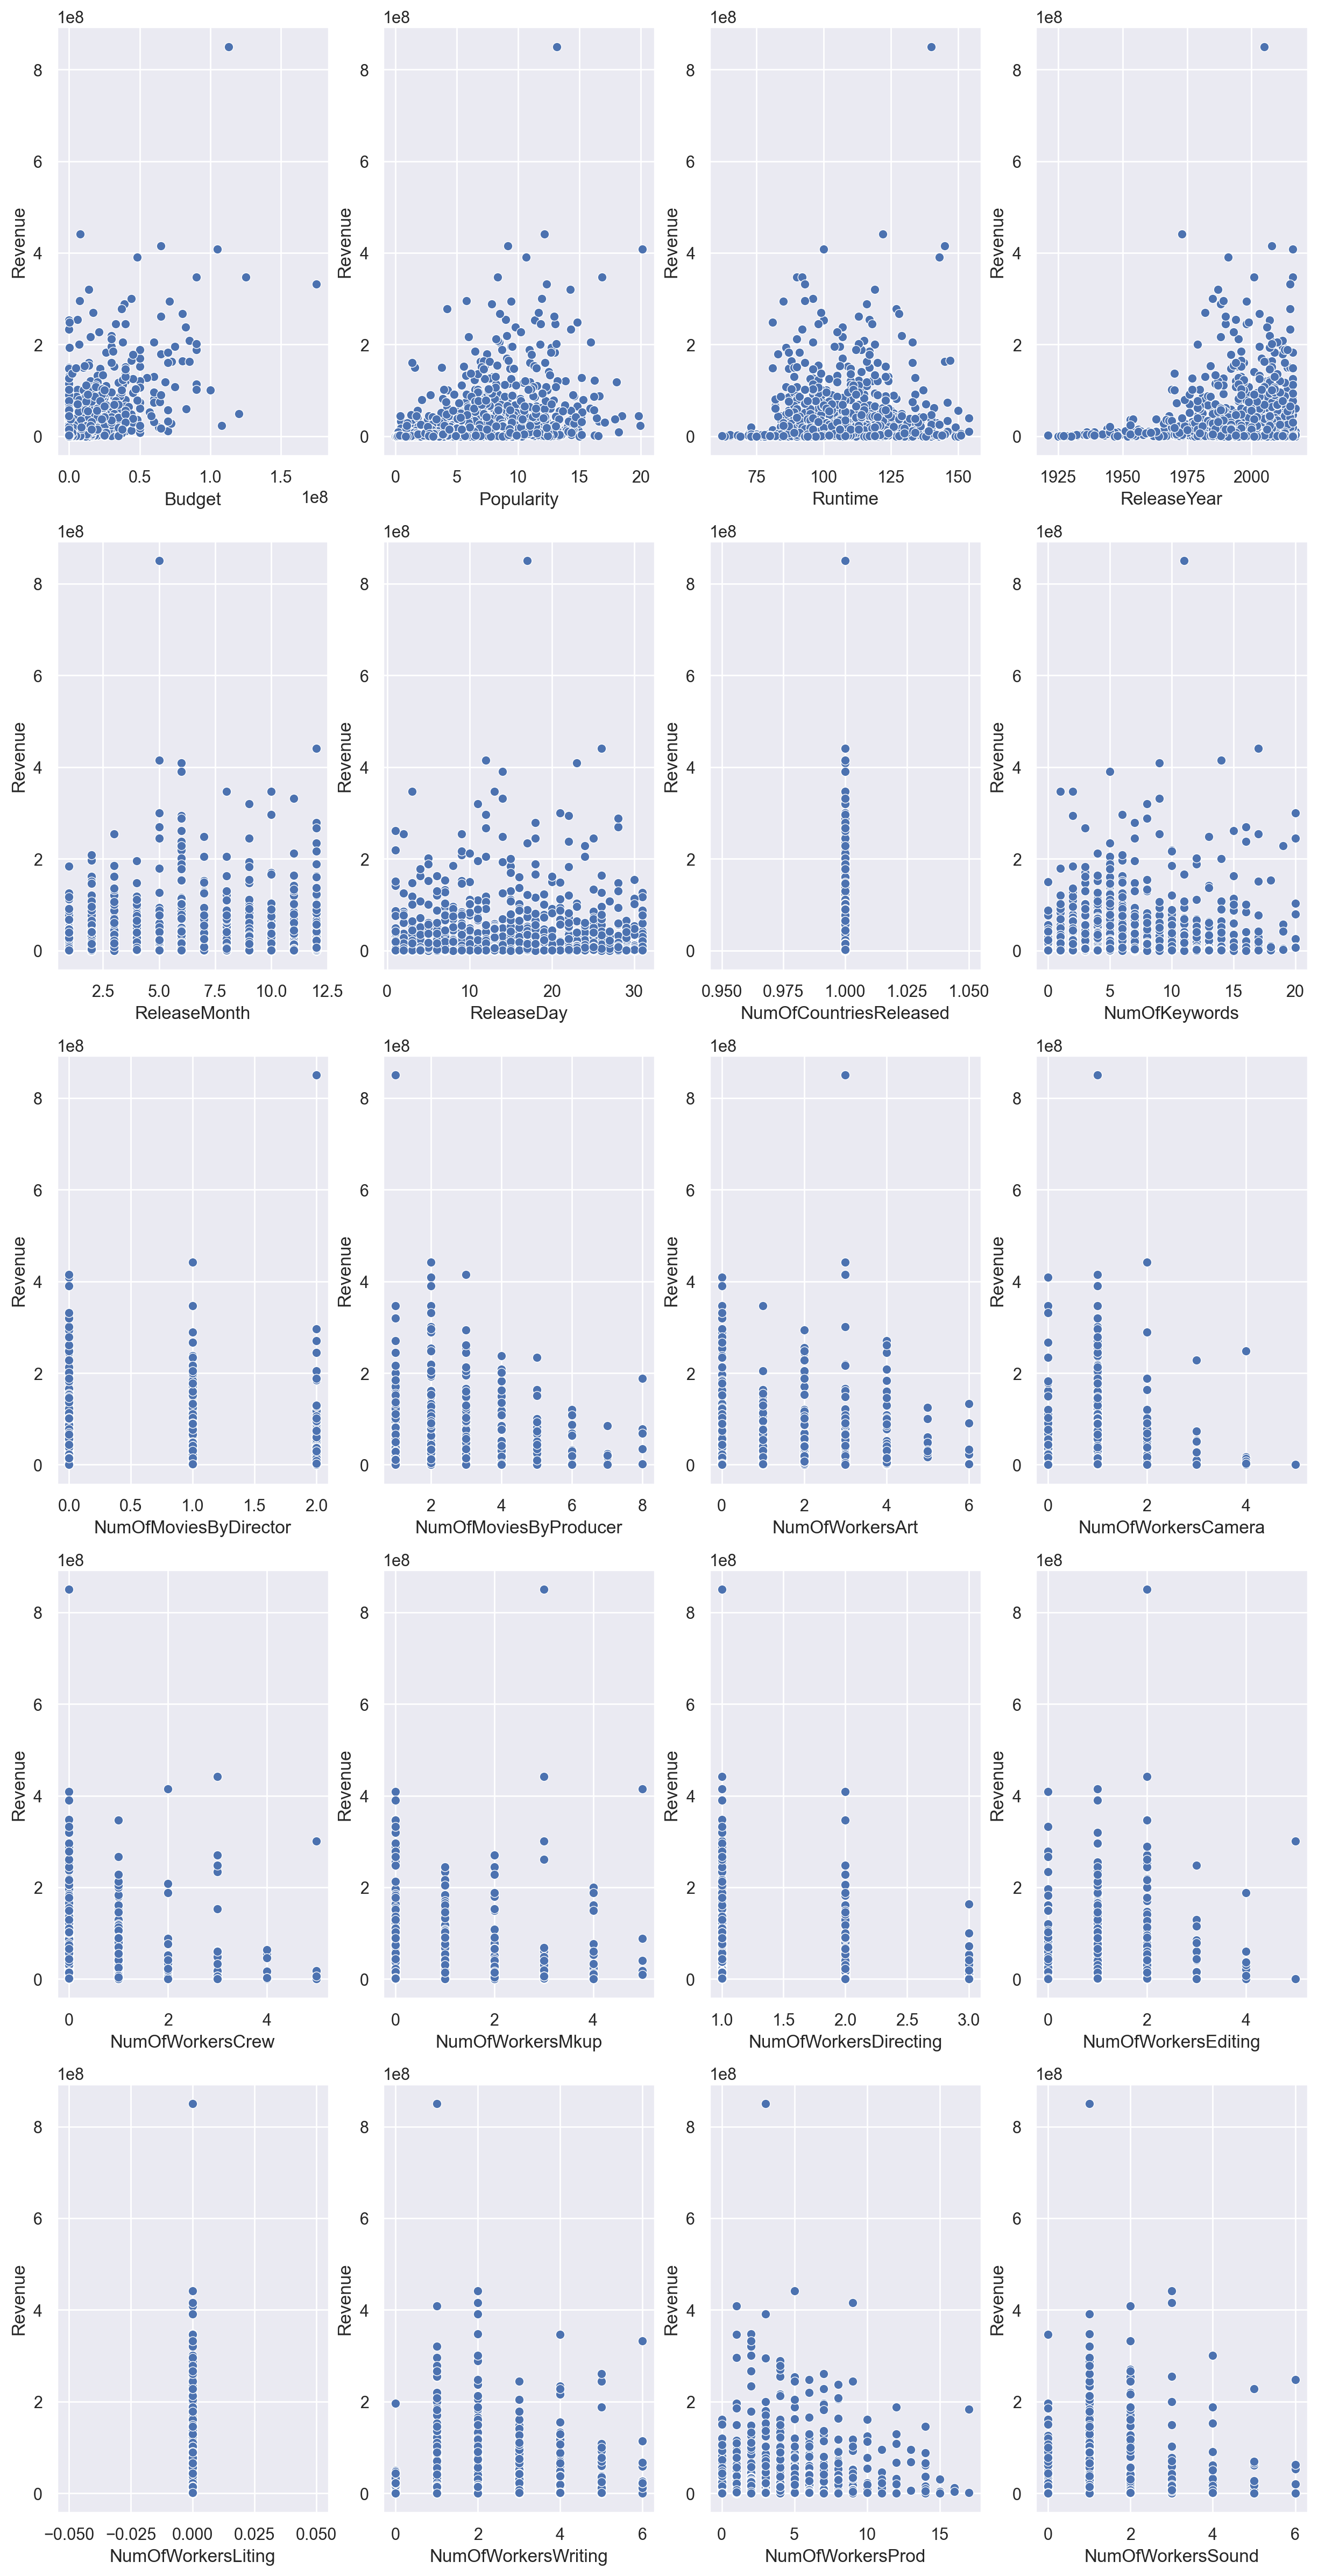

In [160]:
# Plot x~y where y is the target
fig, axes = plt.subplots(nrows=len(numeric_columns) // 4, ncols=4, figsize=(15, 30))
axes = axes.ravel()  # flattening the array makes indexing easier
for col, axis in zip(numeric_columns, axes):
    sns.scatterplot(data=df, x=col, y='Revenue', ax=axis)

After removing the outliers three features can be removed from the df as they all have same value. The features we shall remove are - NumOfWorkersVisualEffects, NumOfWorkersLiting,
NumOfCountriesReleased

In [161]:
# Remove NumOfWorkersVisualEffects, NumOfWorkersLiting, NumOfCountriesReleased Columns
df.drop(['NumOfWorkersVisualEffects', 'NumOfWorkersLiting', 'NumOfCountriesReleased'],
        axis=1, inplace=True)
numeric_columns = [elem for elem in numeric_columns if elem not in ['NumOfWorkersVisualEffects', 'NumOfWorkersLiting', 'NumOfCountriesReleased']]

### Part 3 - Missing values

In [162]:
# create a df without missing values
df_no_missing = df.dropna()
df.shape, df_no_missing.shape

((1294, 36), (1026, 36))

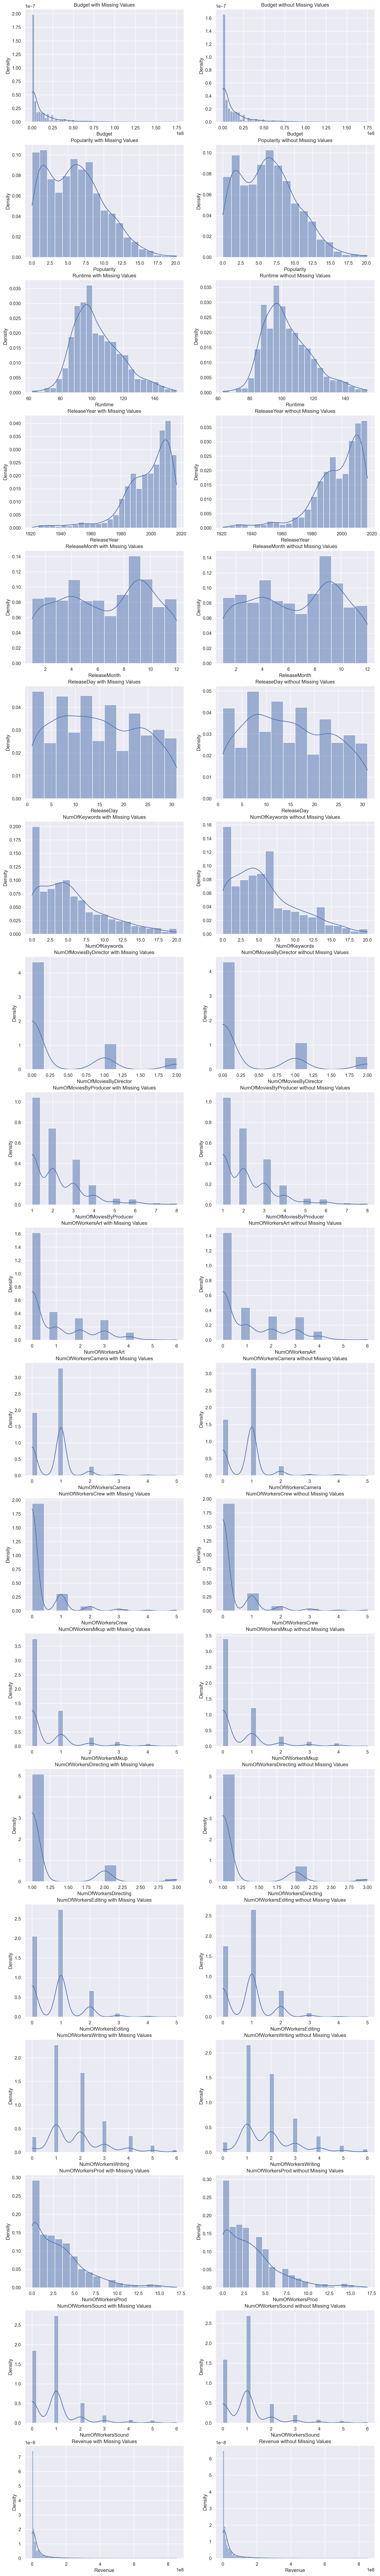

In [163]:
# create hist to explore distribution for each column with and without missing values
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=2, figsize=(15, 110))
axes = axes.ravel()  # flattening the array makes indexing easier

index = 0
duplicate_numeric_columns = [val for val in numeric_columns for _ in (0, 1)]
for col, axis in zip(duplicate_numeric_columns, axes):
    if index % 2 == 0:
        sns.histplot(data=df[numeric_columns], x=col,
                     ax=axis, kde=True, stat='density').set(title=f"{col} with Missing Values")
    else:
        sns.histplot(data=df_no_missing[numeric_columns], x=col,
                     ax=axis, kde=True, stat='density').set_title(f"{col} without Missing Values")
    index += 1
plt.show()